# City infrastructure benchmarking

This notebook presents an analysis of cities using remote-sensing data on macro-level socio-demographic indicators. In particular, we characterize cities by the dependence with distance (from the city center) of several macroeconomic quantities:
* built areas $x_{bldg}(d)$ estimated from SAR/GUF data
* population density $x_{pop}(d)$ estimated from LandScan data
* luminosity $x_{lum}(d)$ estimated from VIIRS (nightlights) data.

We model each quantity (population, luminosity, built area) by breaking it down into a scale component and a spatial profile component:

<p><center> $/displaystyle x(d) = c \cdot \hat{x}(d)$ </center></p>

We analyze cities from the perspective of patterns in each of the components $c$ and $\hat{x}(\cdot)$. We'll have one such set of objects for each data source we consider (population, luminosity, building density).

We expect (as shown empirically below) that the distribution of the scale factor $c$ across cities is heavily skewed towards small $c$, and is approximately a log-normal. 

At the same time, prior research on urban form typically models the relationship of $x (d)$ with distance $d$ using an exponential form:

<p><center> $\displaystyle x(d) = x_0 e^{-\gamma d}$ </center></p>

Above, $\gamma$ is the _average (radial) spatial gradient_ which previous studies (e.g., Alain Bertaud's work) have investigated. This can be estimated readily via linear regression:

<p><center> $\displaystyle \text{log } x(d) = \text{log } x_0 -\gamma d$ </center></p>

(Note we will use 10-base logarithm, but still refer to it as _log_ for ease of notation.)

The two expressions for $x(d)$ are equivalent, so $c$ could be identified as $\text{log }x_0$, but we'll prefer to retain the scale factor $c$, because it has a more direct interpretation. 





# Packages

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import shapely.wkt
from shapely import geometry
import geojson
from shapely.geometry import shape
from shapely.wkt import loads

import re

import sys, os, time
import glob

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import pickle
import copy

colormap = {"bldg":"black", "pop":"green", "lum":"orange", 
            "all":"blue", "bnds":"gray"}

cmap_bld = sns.light_palette("black", n_colors=10)
cmap_pop = sns.light_palette("green", n_colors=10)
cmap_lum = sns.light_palette("orange",n_colors=10)


cmap_dict = {"bldg":ListedColormap(cmap_bld), 
             "pop":ListedColormap(cmap_pop), 
             "lum":ListedColormap(cmap_lum)}


In [1]:
path = "C:/Users/bramv/OneDrive - Square Four/Documenten/Leiden/23-24/urban computing/urbanization-patterns-master/urbanization-patterns-master/"


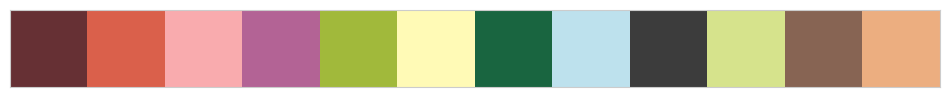

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib

# define a custom color palette
my_colors = [
 (102, 48, 52),
 (218, 96, 75),
 (249, 171, 174),
 (179, 99, 149),
 # (215, 187, 208),
 # (218, 198, 199),
 (161, 185, 59),
 # (214, 227, 140),
 (255, 250, 182),
 (25, 101, 64),
 (189, 225, 237),
 (60, 60, 60),
 (214, 227, 140),
 (135, 100, 83),
 (236, 174, 128)]

my_colors = [(np.array(v)/float(255)).tolist() + [1.0] for v in my_colors]

my_cmap = matplotlib.colors.ListedColormap(my_colors)

sns.palplot(sns.color_palette(my_colors))

# Load city feature data for analysis

#### Data on raw variable profiles with distance

In [2]:
# load pre-computed profile data
import pickle
import gzip

# Provide the correct file path
stats_file_path = path+ "pysatml/home/data/world-cities/spatial-maps/Helsinki.pickle.gz"

# Open the file using gzip for reading
with open(stats_file_path, "rb") as f:
    cities = pickle.load(f)

print(len(cities))

10


In [17]:
cities

{'profiles': {'built': (array([           nan,            nan, 0.00000000e+00, 0.00000000e+00,
          5.97726923e-04, 3.56781497e+00, 4.58471516e+00, 7.79220874e+00,
          9.51160999e+00, 7.71425487e+00, 6.50967910e+00, 5.63114969e+00,
          4.63748441e+00, 3.90887842e+00, 3.83621420e+00, 4.54091862e+00,
          4.66018706e+00, 4.39638121e+00, 4.35154691e+00, 4.56886669e+00,
          5.12936648e+00, 5.48164596e+00, 5.55929772e+00, 5.27475236e+00,
          4.91290563e+00, 4.57361020e+00, 4.31354862e+00, 4.08374032e+00,
          3.89066316e+00, 3.77212288e+00, 4.03555329e+00, 4.35498812e+00,
          4.42798219e+00, 4.48977803e+00, 4.42000231e+00, 4.37340361e+00,
          4.36161470e+00, 4.22283272e+00, 4.14945172e+00, 4.00425177e+00,
          3.90638417e+00, 3.74809002e+00, 3.67621334e+00, 3.55924152e+00,
          3.44153019e+00, 3.30497320e+00, 3.18009709e+00, 3.10700121e+00,
          3.01732639e+00, 2.96338906e+00, 2.90867816e+00, 2.86853792e+00,
          2.80288

In [18]:
mycities = [("helsinki", "finland")]

cities_smpl = {}
for c in mycities:
    for k, v in cities.items():
        if 'city' not in v:
            v['city'] = c[0]
        if 'country' not in v:
            v['country'] = c[1]
        if 'population' not in v:
            v['population'] = 631695
            v['size'] = 'medium'
        cities_smpl[v['city']] = {
            'name': v['city'],
            'country': v['country'],
            'data': (v, k),
        }

# Accessing the information for a specific city
city_name = "paris"
city_info = cities_smpl.get(city_name, None)

if city_info:
    print(f"Name: {city_info['name']}")
    print(f"Country: {city_info['country']}")
    print(f"Data: {city_info['data']}")
else:
    print(f"City '{city_name}' not found.")


City 'paris' not found.


In [19]:
cities

{'profiles': {'built': (array([           nan,            nan, 0.00000000e+00, 0.00000000e+00,
          5.97726923e-04, 3.56781497e+00, 4.58471516e+00, 7.79220874e+00,
          9.51160999e+00, 7.71425487e+00, 6.50967910e+00, 5.63114969e+00,
          4.63748441e+00, 3.90887842e+00, 3.83621420e+00, 4.54091862e+00,
          4.66018706e+00, 4.39638121e+00, 4.35154691e+00, 4.56886669e+00,
          5.12936648e+00, 5.48164596e+00, 5.55929772e+00, 5.27475236e+00,
          4.91290563e+00, 4.57361020e+00, 4.31354862e+00, 4.08374032e+00,
          3.89066316e+00, 3.77212288e+00, 4.03555329e+00, 4.35498812e+00,
          4.42798219e+00, 4.48977803e+00, 4.42000231e+00, 4.37340361e+00,
          4.36161470e+00, 4.22283272e+00, 4.14945172e+00, 4.00425177e+00,
          3.90638417e+00, 3.74809002e+00, 3.67621334e+00, 3.55924152e+00,
          3.44153019e+00, 3.30497320e+00, 3.18009709e+00, 3.10700121e+00,
          3.01732639e+00, 2.96338906e+00, 2.90867816e+00, 2.86853792e+00,
          2.80288

In [20]:
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
# import resize skimage.transform.resize
from skimage.transform import resize

def get_image_data(city_info, imgSize=None, take_log=False):
    fname = files_dict[city_info]
    img = imread(fname)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    f = np.log if take_log else lambda x: x
    mask = img[...,3]==0
    for i in range(3):
        img[...,i] = f(img[...,i]); img[...,i][mask] = np.nan
        img[...,i] = (img[...,i] - np.nanmin(img[...,i])) / float((np.nanmax(img[...,i]) - np.nanmin(img[...,i])))
    return {'bldg':img[...,0], 
            'pop':img[...,1], 
            'lum':img[...,2], 
            'wtr':mask,
            'bnd':img[...,4]} 

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)

import matplotlib.cm as cm

def overlay_mask(img, mask, ax, alpha=0.1, cmap=cm.GnBu):
    masked_data = np.ma.masked_where(mask, img)
    # Overlay the two images
    ax.imshow(img, cmap=cmap)
    ax.imshow(masked_data, cmap=cm.gray, interpolation='none', alpha=alpha)

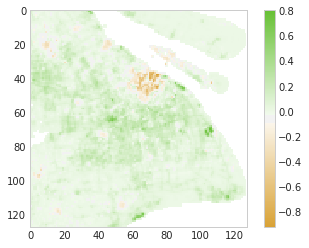

In [137]:
lum_cmap = sns.diverging_palette(55, 120, s=90, l=70, n=20, as_cmap=True)
bld_cmap = sns.diverging_palette(55, 120, s=90, l=70, n=20, as_cmap=True)

plt.imshow(img['lum']-img['pop'], cmap=lum_cmap)
plt.colorbar()

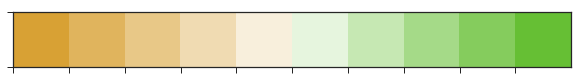

In [447]:
# bld_cmap = sns.diverging_palette(300, 120, s=90, l=70, n=20, as_cmap=True)
sns.palplot(sns.diverging_palette(55, 120, s=90, l=70, n=10))

# Analyze city scale

#### Format scale data

In [68]:
columns_scales = ["bldg-in", "pop-in", "lum-in",
                  "bldg-tot", "pop-tot", "lum-tot",
                  "bldg-max", "pop-max", "lum-max"]

values = ['avg_area_bnds', 'avg_area_bnds',]

# # print avg_area_bnds from cities dictionary
# for k, v in cities.items():
#     for i,j in v.items():
#         print(i)
    

In [21]:
import numpy as np
import pandas as pd

# Assuming cities is your dictionary
# Extracting data for 'Paris'
paris_data = cities

# Extracting scales_within data
scales_within = np.array([
    paris_data.get('avg_area_bnds', {}).get('built', np.nan),
    paris_data.get('population', np.nan),
    paris_data.get('avg_area_bnds', {}).get('lum', np.nan)
]).reshape(1, -1)

# Extracting scales_total data
scales_total = np.array([
    paris_data.get('avg_area', {}).get('built', np.nan),
    paris_data.get('sum_area', {}).get('pop', np.nan),
    paris_data.get('avg_area', {}).get('lum', np.nan)
]).reshape(1, -1)

# Extracting scales_max data
scales_max = np.array([
    np.nanmax(paris_data.get('profiles', {}).get('built', [np.nan])),
    np.nanmax(paris_data.get('profiles', {}).get('pop', [np.nan])),
    np.nanmax(paris_data.get('profiles', {}).get('lum', [np.nan]))
]).reshape(1, -1)

# Combine all scales data
scales = np.hstack([scales_within, scales_total, scales_max])

# Define columns for scales_df
columns_scales = ["bldg-in", "pop-in", "lum-in",
                  "bldg-tot", "pop-tot", "lum-tot",
                  "bldg-max", "pop-max", "lum-max"]

# Create scales_df
scales_df = pd.DataFrame(scales, columns=columns_scales)

# Create info_df for Paris
info_df = pd.DataFrame({
    'city': [paris_data.get('city')],
    'country': [paris_data.get('country', '')],
    'population': [int(float(paris_data.get('population', 0)))],
    'scale-pop': [paris_data.get('size', '')]
})

# Concatenate info_df and scales_df
result_df = pd.concat([info_df, scales_df], axis=1)

result_df.fillna(0, inplace=True)  # Fill NaN values with 0

result_df.head()


,city,country,population,scale-pop,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max
0,0,,0,,8.974204,0.0,0.578031,2.652292,2383276.0,0.232997,20.654978,182.906306,1.0


In [22]:
result_df['city'] = 'helenski'
result_df['country'] = 'finland'
result_df['population'] = 631695
result_df['scale-pop'] = 'medium'
result_df['pop-in'] = 631695.0

In [56]:
result_df.drop(['coutry'], axis=1, inplace=True)

In [23]:
result_df.head()

,city,country,population,scale-pop,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max
0,helenski,finland,631695,medium,8.974204,631695.0,0.578031,2.652292,2383276.0,0.232997,20.654978,182.906306,1.0


In [143]:
scales_df.dtypes

city           object
country        object
population      int64
scale-pop      object
subregion      object
region         object
bldg-in       float64
pop-in        float64
lum-in        float64
bldg-tot      float64
pop-tot       float64
lum-tot       float64
bldg-max      float64
pop-max       float64
lum-max       float64
dtype: object

# Analyze "discrepancy" between $x_{bld}(d)$, $x_{pop}(d)$, and $x_{lum}(d)$ profiles

We take as reference the population distribution profile $x_{pop}$. We then define discrepancy through Earth Mover's Distance, i.e., the amount of work needed to transform $x_{bld}$ and $x_{lum}$ into $x_{pop}$.

In [24]:
from pyemd import emd, emd_with_flow
from scipy.linalg import toeplitz

def find_sign_change_array(a):
    asign = np.sign(a)
    sz = asign == 0
    if sz.any():
        asign[sz] = np.roll(asign, 1)[sz]
        sz = asign == 0
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    return signchange

def get_regions(a):
    sgn = find_sign_change_array(a)
    regs= []
    i = 0
    for j,s in enumerate(sgn):
        if s==1:
            regs += [(i,j,np.sign(a[i]))]
            i = j
    if i<j:
        regs += [(i,j,np.sign(a[i]))]
    return regs

a = np.array([1,1,-1,0, -2,-3,4,5])
print (a)
print (find_sign_change_array(a))
print (get_regions(a))

[ 1  1 -1  0 -2 -3  4  5]
[0 0 1 0 0 0 1 0]
[(0, 2, 1), (2, 6, -1), (6, 7, 1)]


(0.4134680080250869, [(0, 8, -0.3033769988664081), (8, 40, 0.611807550316567), (40, 49, -0.8864453155721209)])


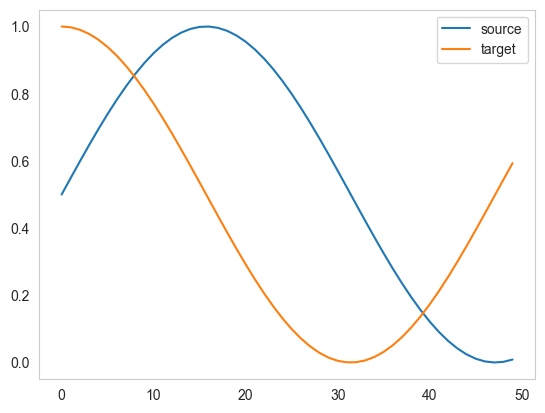

In [25]:
def compute_discrepancy(source0, target0, weights=None):
    weights = np.ones(len(source0)) if weights is None else weights
    source = weights * source0
    target = weights * target0
    dif = source - target
    reg = get_regions(dif)
    top = np.array([max([i,j]) for i,j in zip(source,target)])
    tot_disc = dif.sum()/float(target.sum())
    disc=[]
    for (i,j,s) in reg:
        d = dif[i:j].sum() / float(top[i:j].sum())
        disc += [(i,j,d)]
    return tot_disc, disc

src = 0.5*(1 + np.sin(np.arange(0,5,0.1)))
trg = 0.5*(1 + np.cos(np.arange(0,5,0.1)))
discr = compute_discrepancy(src, trg)
print (discr)
plt.plot(src, label="source")
plt.plot(trg, label="target")
plt.legend(loc="best")

In [26]:
# Assuming mu_pop and mu_lum are your arrays with nan values
mu_pop = cities['profiles']['pop'][0]
mu_lum = cities['profiles']['lum'][0]

# Identify nan values and filter them out
nan_indices_pop = np.isnan(mu_pop)
nan_indices_lum = np.isnan(mu_lum)

# Filter out nan values from both arrays
mu_pop = mu_pop[~nan_indices_pop]
mu_lum = mu_lum[~nan_indices_lum]

mu_pop = mu_pop/mu_pop.max()
mu_lum = mu_lum/mu_lum.max()


dis_lum, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)

print (dis_lum)
print (dis_lum_reg)

0.07713437406997424
[(0, 7, 0.48620862616903715), (7, 10, -0.06421665982558988), (10, 19, 0.1913809893191675), (19, 51, -0.11766007334547507), (51, 87, 0.06568609782742117)]


In [113]:
mu_pop

array([0.9969486 , 1.        , 0.9514994 , 0.92777524, 0.83852597,
       0.72048822, 0.63780356, 0.56593357, 0.51404541, 0.47370183,
       0.43601978, 0.4008998 , 0.37013092, 0.34076571, 0.31640656,
       0.28823067, 0.26492089, 0.24502538, 0.22797799, 0.20868046,
       0.19248516, 0.1779313 , 0.16518792, 0.15413018, 0.14487649,
       0.13760709, 0.131045  , 0.1242661 , 0.11802819, 0.11181205,
       0.10554268, 0.10015435, 0.09529017, 0.09053766, 0.08581322,
       0.08177435, 0.0774777 , 0.07396395, 0.07073388, 0.06783563,
       0.06508106, 0.06241047, 0.05976896, 0.05738264, 0.05518732,
       0.05306954, 0.05098861, 0.04914276, 0.04729694, 0.04557898,
       0.04409917, 0.0424436 , 0.04101577, 0.03973042, 0.03863518,
       0.03759941, 0.03664276, 0.03568693, 0.03477463, 0.03380472,
       0.03279566, 0.03185978, 0.03096785, 0.03016552, 0.02937114,
       0.02855521, 0.02780557, 0.02711502, 0.02642117, 0.02577031,
       0.025157  , 0.02453016, 0.02390944, 0.02336402, 0.02279

In [114]:
mu_lum

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999968, 0.99873082,
       0.99796652, 0.99605375, 0.99247849, 0.99277315, 0.99332963,
       0.99381899, 0.99215881, 0.98717111, 0.97888489, 0.96672914,
       0.95840066, 0.94904725, 0.93966578, 0.93407908, 0.92867695,
       0.9238861 , 0.91637319, 0.90881509, 0.90329678, 0.89817654,
       0.89345343, 0.88888906, 0.88524639, 0.88013566, 0.87334088,
       0.86315259, 0.85209294, 0.84758875, 0.84359534, 0.8403371 ,
       0.83853771, 0.83586915, 0.83387546, 0.83188883, 0.82915752,
       0.82714112, 0.82396017, 0.82318317, 0.82100267, 0.81674626,
       0.81207056, 0.80747738, 0.80450001, 0.80172445, 0.79841379,
       0.79617173, 0.7956806 , 0.79434829, 0.79039349, 0.78758878,
       0.78458649, 0.78077047, 0.77512632, 0.76860814, 0.76192

In [61]:
from scipy.stats import wasserstein_distance

def compute_effort_emd(source, target, weights=None):
    return wasserstein_distance(source, target, u_weights=weights, v_weights=weights)

def compute_effort_emd2(source0, target0, weights=None):
    weights = np.ones(len(source0)) if weights is None else weights
    dist_mat = toeplitz(np.arange(len(target0))).astype(float)
    source = weights * source0
    target = weights * target0
    # dist_mat = (-np.tril(dist_mat) + np.triu(dist_mat)).astype(float)
    # dist_mat = np.ones((len(source), len(target)))
    dist_emd, flow_emd = emd_with_flow(source, target, dist_mat)
    return dist_emd

def compute_emd_regions(source, target, weights=None):
    weights = np.ones(len(source)) if weights is None else weights
    reg = get_regions(source-target)
    emd = []
    for i,j,s in reg:
        d = compute_effort_emd(source[i:j], target[i:j], weights=weights[i:j])
        d = d*s if d !=0 else d
        emd.append((i,j,d))
    return emd

### Show example discrepancy computation

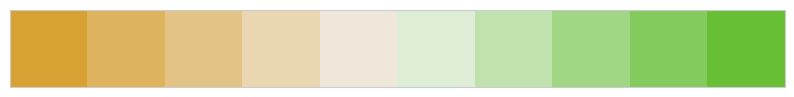

In [62]:
dif_lum_pop_cmap = sns.diverging_palette(55, 120, s=90, l=70, n=20, as_cmap=True)

# bld_cmap = sns.diverging_palette(300, 120, s=90, l=70, n=20, as_cmap=True)
sns.palplot(sns.diverging_palette(55, 120, s=90, l=70, n=10))

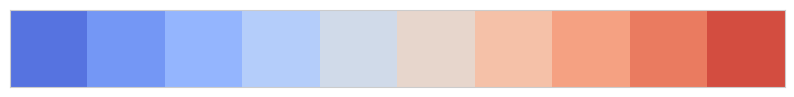

In [63]:
sns.palplot(sns.color_palette("coolwarm", 10))

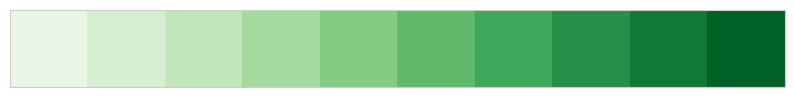

In [64]:
sns.palplot(sns.color_palette("Greens", 10))

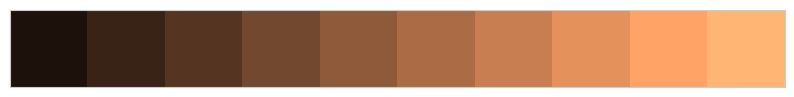

In [65]:
sns.palplot(sns.color_palette("copper", 10))

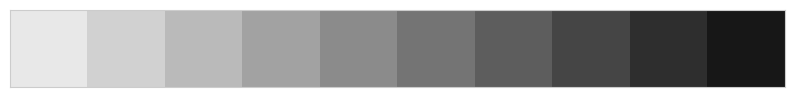

In [66]:
sns.palplot(sns.color_palette("gray_r", 10))

nan
[(0, 1, nan), (1, 2, nan), (2, 3, nan), (3, 4, nan), (4, 5, nan), (5, 6, nan), (6, 7, nan), (7, 8, nan), (8, 9, nan), (9, 10, nan), (10, 11, nan), (11, 12, nan), (12, 13, nan), (13, 14, nan), (14, 15, nan), (15, 16, nan), (16, 17, nan), (17, 18, nan), (18, 19, nan), (19, 20, nan), (20, 21, nan), (21, 22, nan), (22, 23, nan), (23, 24, nan), (24, 25, nan), (25, 26, nan), (26, 27, nan), (27, 28, nan), (28, 29, nan), (29, 30, nan), (30, 31, nan), (31, 32, nan), (32, 33, nan), (33, 34, nan), (34, 35, nan), (35, 36, nan), (36, 37, nan), (37, 38, nan), (38, 39, nan), (39, 40, nan), (40, 41, nan), (41, 42, nan), (42, 43, nan), (43, 44, nan), (44, 45, nan), (45, 46, nan), (46, 47, nan), (47, 48, nan), (48, 49, nan), (49, 50, nan), (50, 51, nan), (51, 52, nan), (52, 53, nan), (53, 54, nan), (54, 55, nan), (55, 56, nan), (56, 57, nan), (57, 58, nan), (58, 59, nan), (59, 60, nan), (60, 61, nan), (61, 62, nan), (62, 63, nan), (63, 64, nan), (64, 65, nan), (65, 66, nan), (66, 67, nan), (67, 68, 

In [79]:
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec


nimg = 2
ncol = 5

mycities = [("paris", "france")
#             ("rio de janeiro", "brazil"), 
#             ("san francisco", "united states"), 
#             ("barcelona", "spain"),
#             ("mumbai city", "india"), 
            ]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(16,6))
gs1 = gridspec.GridSpec(nimg,ncol)
gs1.update(wspace=0.01, hspace=0.04) # set the spacing between axes. 

for i,c in enumerate(mycities):

    
    city,smpl_name = cities_smpl[c[0]]
    mu_pop = city['profiles']['pop'][0]
    mu_pop = mu_pop/mu_pop.max()
    mu_lum = city['profiles']['lum'][0]
    mu_lum = mu_lum/mu_lum.max()
    mu_bnd = city['profiles']['bnds'][0]
    
    # compute discrepancy
    dis_lum, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)
    
    print (dis_lum)
    print (dis_lum_reg)
    
    r = scales_df[(scales_df.city == c[0]) & (scales_df.country==c[1])].iloc[0]
    img = get_image_data((r['city'], r['country'], r['population']))
    bounds_mask = img['bnd']
    city_pop = r['population']
    cityname = c[0]

    # plot built areas
    ax0 = plt.subplot(gs1[i,0]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(img['bldg'], bounds_mask>0, ax0, cmap="gray_r"); ax0.set_title("built areas \n (SAR)") if i==0 else None
    # plot Nightlights
    ax1 = plt.subplot(gs1[i,1]); ax1.set_xticks([]); ax1.set_yticks([])
    ax1.imshow(img['lum'], cmap="copper"); ax1.set_title("nightlights \n (VIIRS)") if i==0 else None
    # plot population
    ax2 = plt.subplot(gs1[i,2]); ax2.set_xticks([]); ax2.set_yticks([])
    ax2.imshow(img['pop'],cmap="Greens"); ax2.set_title("population \n (LandScan)") if i==0 else None
    ax0.set_ylabel("%s\n(pop %s)"%(cityname, format_pop(city_pop)))
    
    # plot difference lum - pop
    ax4 = plt.subplot(gs1[i,3]); ax4.set_xticks([]); ax4.set_yticks([])
    ax4.imshow(img['lum']/float(np.nanmax(img['lum']))-img['pop']/float(np.nanmax(img['pop'])),
               cmap="bwr"); 
    ax4.set_title("normalized difference\n $\hat x_{lum}-\hat x_{pop}$") if i==0 else None
    
    
    # plot profiles
    ax3 = plt.subplot(gs1[i,4]); ax3.set_xticks([]); ax3.set_yticks([])
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = city['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        ax3.plot(distance_km[2:], mu / scale, lw=3, label=s, color=colormap[s])
    if i == 0:
        ax3.set_title("$\hat x_{\cdot}(d)$")
        ax3.legend(loc="best", prop={'size': 8})
    ax3.set_xlabel("$d \ [km]$")    
    
    for p,q,d in dis_lum_reg:
        ax3.fill_between(distance_km[p:q], mu_lum[p:q], mu_pop[p:q], 
                             facecolor="red" if d<0 else "cornflowerblue",
                             interpolate=True, alpha=0.4)
fig.savefig('../figures/paper_figure_1.svg', 
            format='svg', dpi=1200, bbox_inches='tight')
fig.show()


KeyError: 'paris'

<Figure size 1600x600 with 0 Axes>

### Compute EMD effort/discrepancy (bld->pop, lum->pop) for all cities

In [285]:
discrepancy = []
effort_emd = []
for i in range(Xbld_hat.shape[0]):
    clear_output(True)
    print i, "/", len(Xbld_hat)
    mu_bld = Xbld_hat[i,:]
    mu_pop = Xpop_hat[i,:]
    mu_lum = Xlum_hat[i,:]
    mu_bnd = Xbnd[i,:];
    if mu_bnd.sum()==0:
        weights_in = None
        weights_out=None
    else:
        weights_in = mu_bnd
        weights_out = 1 - mu_bnd
    
    # compute normalized discrepancy
    dis_bld_tot, dis_bld_reg = compute_discrepancy(mu_bld, mu_pop)
    dis_lum_tot, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)
    dis_bld_tot_in, dis_bld_reg_in = compute_discrepancy(mu_bld, mu_pop, weights=weights_in)
    dis_lum_tot_in, dis_lum_reg_in = compute_discrepancy(mu_lum, mu_pop, weights=weights_in)
    dis_bld_tot_out, dis_bld_reg_out = compute_discrepancy(mu_bld, mu_pop, weights=weights_out)
    dis_lum_tot_out, dis_lum_reg_out = compute_discrepancy(mu_lum, mu_pop, weights=weights_out)
    discrepancy.append([dis_bld_tot, dis_bld_tot_in, dis_bld_tot_out, 
                        dis_lum_tot, dis_lum_tot_in, dis_lum_tot_out])
    
    # compute EMD effort
    emd_bld = compute_effort_emd(mu_bld, mu_pop)
    emd_lum = compute_effort_emd(mu_lum, mu_pop)
    emd_bld_in = compute_effort_emd(mu_bld, mu_pop, weights=weights_in)
    emd_lum_in = compute_effort_emd(mu_lum, mu_pop, weights=weights_in)
    emd_bld_out = compute_effort_emd(mu_bld, mu_pop, weights=weights_out)
    emd_lum_out = compute_effort_emd(mu_lum, mu_pop, weights=weights_out)
    effort_emd.append([emd_bld, emd_bld_in, emd_bld_out, emd_lum, emd_lum_in, emd_lum_out])
    #emd_bld_reg = compute_emd_regions(mu_bld, mu_pop)
    # emd_lum_reg = compute_emd_regions(mu_lum, mu_pop)
    
effort_emd = pd.DataFrame(np.array(effort_emd), 
                          columns=["bldg", "bldg-in", "bldg-out", "lum", "lum-in", "lum-out"])
effort_emd = pd.concat([info_df, effort_emd], axis=1)
discrepancy = pd.DataFrame(np.array(discrepancy), 
                           columns=["bldg", "bldg-in", "bldg-out", "lum", "lum-in", "lum-out"])
discrepancy = pd.concat([info_df, discrepancy], axis=1)

6935 / 6936


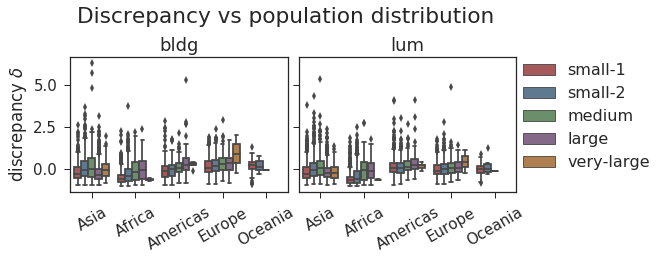

In [286]:
fig, ax = plt.subplots(1,2, figsize=(8,3), 
                       gridspec_kw={"wspace":0.05, "hspace":0.1},
                       sharex=True, sharey=True)

for a,src in zip(ax, ['bldg', "lum"]):
    sns.boxplot(x="region", y=src, hue="scale-pop", palette=pop_colors,
                data=discrepancy, ax=a, hue_order=pop_scales)
    a.set_xlabel(""); a.set_ylabel(""); 
    a.set_xticklabels(a.get_xticklabels(), rotation=30)
    a.set_title(src)
    a.legend_.remove()
    
ax[0].set_ylabel("discrepancy $\delta$")
ax[-1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))
fig.subplots_adjust(top=0.75)
fig.suptitle("Discrepancy vs population distribution")

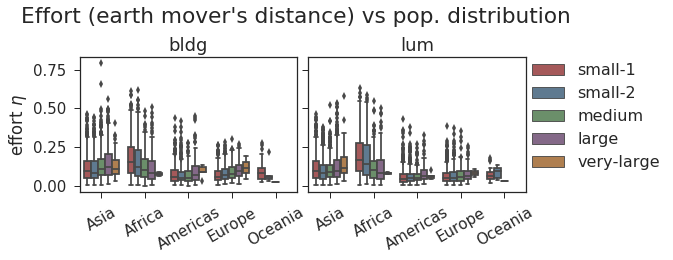

In [287]:
fig, ax = plt.subplots(1,2, figsize=(8,3), 
                       gridspec_kw={"wspace":0.05, "hspace":0.1},
                       sharex=True, sharey=True)

for a,src in zip(ax, ['bldg', "lum"]):
    cur_df = effort_emd
    sns.boxplot(x="region", y=src, hue="scale-pop", palette=pop_colors,
                data=effort_emd, ax=a, hue_order=pop_scales)
    a.set_xlabel(""); a.set_ylabel(""); 
    a.set_xticklabels(a.get_xticklabels(), rotation=30)
    a.set_title(src)
    a.legend_.remove()
    
ax[0].set_ylabel("effort $\eta$")
ax[-1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))
fig.subplots_adjust(top=0.75)
fig.suptitle("Effort (earth mover's distance) vs pop. distribution")

##### Effort $\eta$ vs discrepancy $\delta$ for normalized profiles $\hat x_{\cdot}(d)$

kinshasa -0.531631520022 -1.18665896691
casablanca 0.511126276158 -1.16244334301


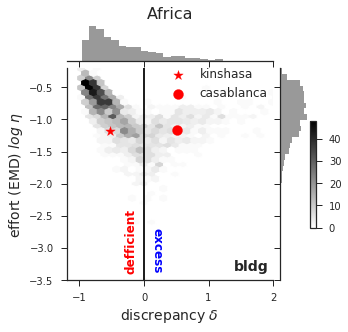

san francisco -0.324005661907 -1.09051530128
rio de janeiro 0.383029441021 -1.06872226897


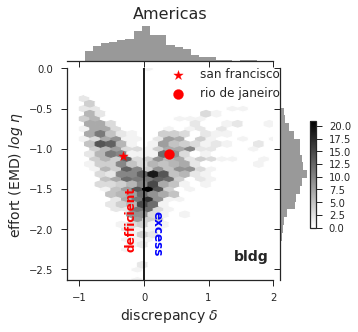

mumbai city 1.64982439815 -0.726926687059
shanghai 0.363449409345 -0.81406668768


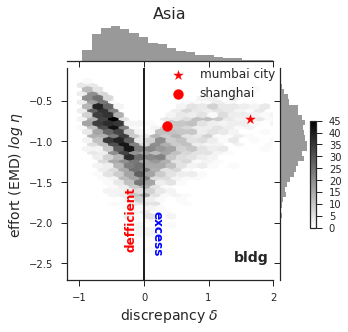

paris 1.74449032921 -0.593776541106
barcelona -0.190292573675 -1.34380794285


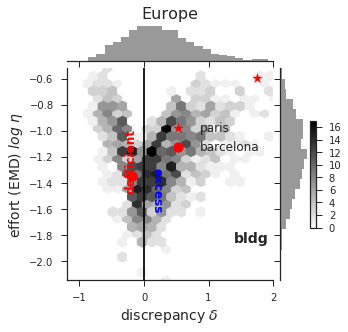

kinshasa -0.59821131812 -1.13604214221
casablanca 0.534244722742 -1.13517650706


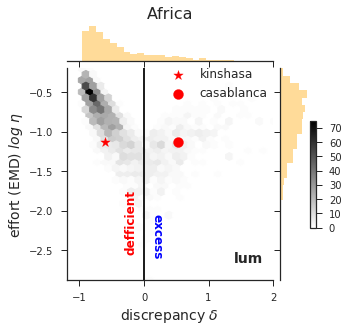

san francisco 0.106928451106 -1.41774141594
rio de janeiro 0.264347346785 -1.22451467993


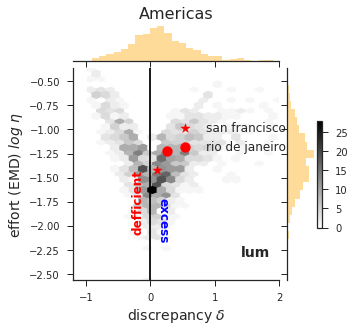

mumbai city 1.43906634818 -0.787761767746
shanghai 0.167209355338 -0.997010024961


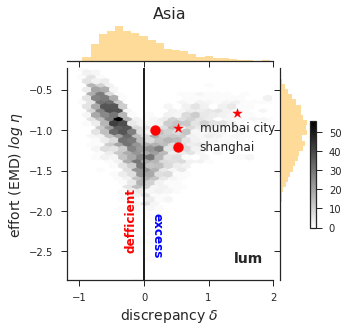

paris 0.6861223935 -0.967499829238
barcelona -0.20378215112 -1.23216551492


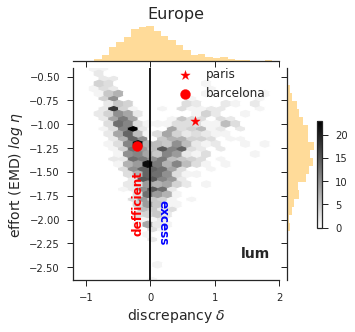

In [342]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

cities_region = {
    "Africa":["kinshasa", 'casablanca'],
    "Americas":["san francisco", "rio de janeiro"],
    "Asia":["mumbai city", "shanghai"],
    "Europe":['paris', 'barcelona']
}

for src in ["bldg", "lum"]:
    for r in ['Africa', 'Americas', 'Asia', 'Europe']:
        idx = info_df['region']==r
        # pop = info_df['population'][idx].astype(float)
        pop = scales_df['pop-max'][idx].astype(float)
        scl = scales_df['%s-max'%src][idx].astype(float)
        emd = effort_emd["%s"%src][idx]
        eta = np.log10(emd)# *scl*pop)
        eta[np.isinf(eta) | np.isneginf(eta)] = 0
        delta = discrepancy["%s"%src][idx]
        delta[np.isinf(delta)] = 0
        g = sns.jointplot(delta, eta, 
                          kind="hex", color=colormap[src], size=4.5, stat_func=None,
                          xlim=(-1.2,2), 
                          # ylim=(-100,1200), 
                          cmap=cm.gray_r)
        g.ax_joint.set_xlabel("discrepancy $\delta$", fontsize=14)
        g.ax_joint.set_ylabel("effort (EMD) $log \ \eta$", fontsize=14)
        g.ax_marg_x.set_title(r, fontsize=16)
        g.ax_joint.axvline(x=0, color=colormap["bldg"])
        g.ax_joint.annotate("defficient", xy=(-0.3, 1.3+min(eta)*1.1), color="red", 
                            weight='bold', rotation=90)
        g.ax_joint.annotate("excess", xy=(0.1, 1+min(eta)*1.1), color="blue", 
                            weight='bold', rotation=-90)
        g.ax_joint.annotate(src, xy=(1.4, 0.5+min(eta)*1.1), fontsize=14,
                            weight='bold') 
                            #color=colormap[src])
        for c,m in zip(cities_region[r], ["*", 'o']):
            idx_c = (info_df['city']==c) & (info_df['region']==r)
            x,y = delta[idx_c].iloc[0], eta[idx_c].iloc[0]
            print c, x, y
            g.ax_joint.scatter(x, y, label=c, marker=m, s=100, color='red')
        g.ax_joint.legend(loc="best", bbox_to_anchor=(0.43, 0.8), fontsize=12)
        plt.colorbar()
        plt.show()
        
        g.fig.savefig('../figures/density_discrepancy_effort_%s_%s.svg' % (src, r), 
                      format='svg', dpi=1200, bbox_inches='tight')
        g.fig.show()


##### Effort $\eta$ vs discrepancy $\delta$ scaled by $max \ x_{pop}(d)$ and  $max \ x_{lum}(d)$ 

kinshasa -0.531631520022 0.108321916878
casablanca 0.511126276158 3.0109350166


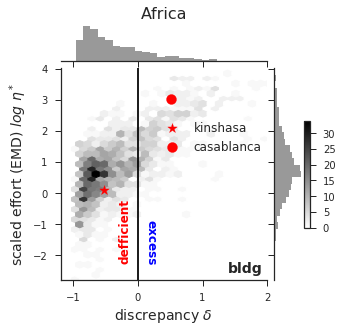

san francisco -0.324005661907 1.51805242071
rio de janeiro 0.383029441021 2.58389679327


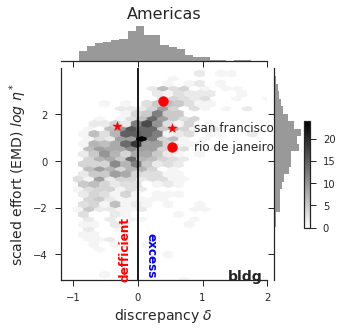

mumbai city 1.64982439815 3.97289051844
shanghai 0.363449409345 3.04651630623


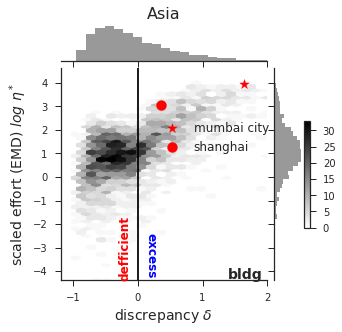

paris 1.74449032921 3.76502803653
barcelona -0.190292573675 0.306505483913


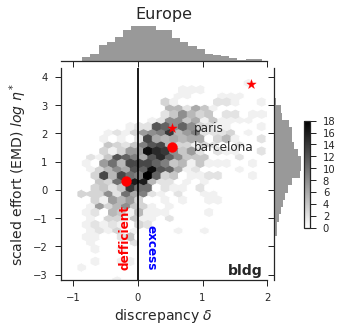

kinshasa -0.59821131812 0.833505524646
casablanca 0.534244722742 4.92926811649


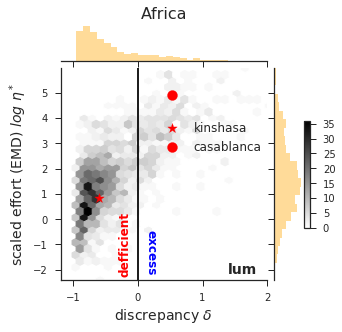

san francisco 0.106928451106 2.93439961695
rio de janeiro 0.264347346785 4.40049746479


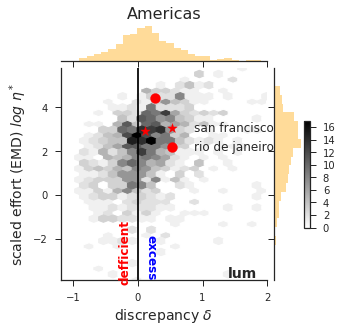

mumbai city 1.43906634818 5.55539992682
shanghai 0.167209355338 4.55933464753


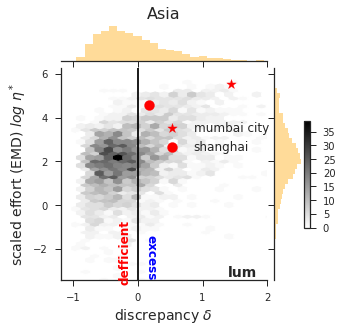

paris 0.6861223935 5.41766569362
barcelona -0.20378215112 2.15489031633


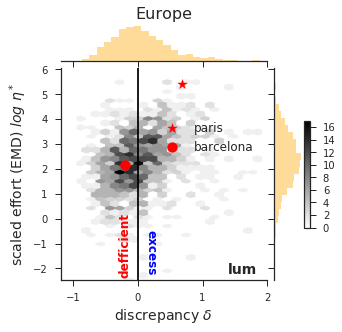

In [292]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

cities_region = {
    "Africa":["kinshasa", 'casablanca'],
    "Americas":["san francisco", "rio de janeiro"],
    "Asia":["mumbai city", "shanghai"],
    "Europe":['paris', 'barcelona']
}

for src in ["bldg", "lum"]:
    for r in ['Africa', 'Americas', 'Asia', 'Europe']:
        idx = info_df['region']==r
        pop = scales_df['pop-max'][idx].astype(float)
        scl = scales_df['%s-max'%src][idx].astype(float)
        emd = effort_emd["%s"%src][idx]
        eta = np.log10(emd *scl*pop)
        eta[np.isinf(eta) | np.isneginf(eta)] = 0
        delta = discrepancy["%s"%src][idx]
        delta[np.isinf(delta)] = 0
        g = sns.jointplot(delta, eta, 
                          kind="hex", color=colormap[src], size=4.5, stat_func=None,
                          xlim=(-1.2,2), 
                          # ylim=(-100,1200), 
                          cmap=cm.gray_r)
        g.ax_joint.set_xlabel("discrepancy $\delta$", fontsize=14)
        g.ax_joint.set_ylabel("scaled effort (EMD) $log \ \eta^*$", fontsize=14)
        g.ax_marg_x.set_title(r, fontsize=16)
        g.ax_joint.axvline(x=0, color=colormap["bldg"])
        g.ax_joint.annotate("defficient", xy=(-0.3, 2.3+min(eta)), color="red", 
                            weight='bold', rotation=90)
        g.ax_joint.annotate("excess", xy=(0.1, 1.6+min(eta)), color="blue", 
                            weight='bold', rotation=-90)
        g.ax_joint.annotate(src, xy=(1.4, 0.5+min(eta)*1.1), fontsize=14,
                            weight='bold') 
                            #color=colormap[src])
        for c,m in zip(cities_region[r], ["*", 'o']):
            idx_c = (info_df['city']==c) & (info_df['region']==r)
            x,y = delta[idx_c].iloc[0], eta[idx_c].iloc[0]
            print c, x, y
            g.ax_joint.scatter(x, y, label=c, marker=m, s=100, color='red')
        g.ax_joint.legend(loc="best", bbox_to_anchor=(0.43, 0.8), fontsize=12)
        plt.colorbar()
        plt.show()
        
        g.fig.savefig('../figures/density_discrepancy_effort_scaled_%s_%s.svg' % (src, r), format='svg', dpi=1200)
        g.fig.show()

##### Effort inside vs outside of the city boundaries

In [294]:
pct_in = info_df.copy()
pct_in['eta_lum'] = effort_emd['lum-in'] / (effort_emd['lum-in']+effort_emd['lum-out'])
pct_in['eta_bldg'] = effort_emd['bldg-in'] / (effort_emd['bldg-in']+effort_emd['bldg-out'])
pct_in.head()

,city,country,population,scale-pop,subregion,region,eta_lum,eta_bldg
0,shahdol,india,1237432,large,Southern Asia,Asia,0.299228,0.511636
1,lafia,nigeria,364173,small-2,Western Africa,Africa,0.564823,0.514595
2,ibarapa central,nigeria,120329,small-1,Western Africa,Africa,0.662537,0.676835
3,hamilton,united states,360445,small-2,Northern America,Americas,0.609442,0.913973
4,purnia,india,3385281,large,Southern Asia,Asia,0.455734,0.483794


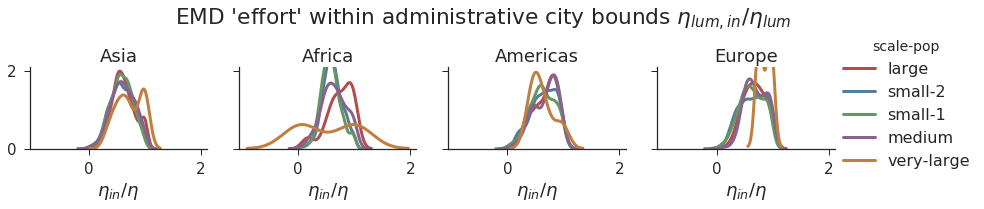

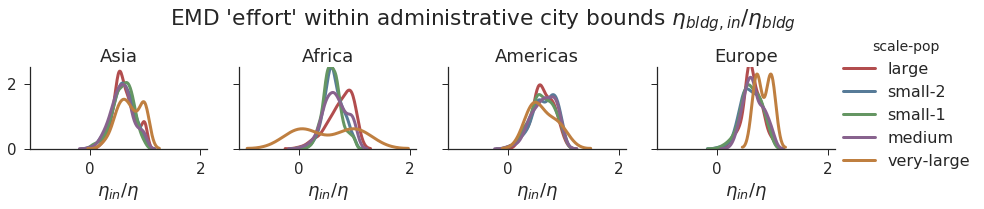

In [295]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks", font_scale=1.5)

for src in ["lum", "bldg"]:
    g = sns.FacetGrid(pct_in[pct_in.region!='Oceania'], 
                      col="region", hue="scale-pop", palette=pop_colors)
    g = (g.map(sns.kdeplot, "eta_%s"%src, lw=3).add_legend(fontsize=16))
    for a in g.axes.flatten():
        a.set_xlabel("$\eta_{in}/\eta$", fontsize=18)
        a.set_title(a.get_title().split(" = ")[1], fontsize=18)
    g.fig.subplots_adjust(top=0.7)
    g.fig.suptitle("EMD 'effort' within administrative city bounds $\eta_{%s,in}/\eta_{%s}$"%(src,src))    

# Benchmark target variable (luminosity) against others 

### Exponential model across all cities via linear regression

Let's set up a regression model across all cities similar to the exponential model for a given city, with fixed effects for regions, subregions, scales etc. and different coefficients for $\gamma$ across subregions. 


In [296]:
N, D = Xbld_hat_log.shape
regions = scales_df['region'].unique()
scales_df['population'] = scales_df['population'].apply(lambda x: int(float(x)))
R = len(regions)
subregions = scales_df['subregion'].unique().tolist()
SR = len(subregions)

features_X = np.vstack([Xbld_hat_log.flatten(), 
                        Xpop_hat_log.flatten(), 
                        Xbnd.flatten()]).T

# TODO: implement interaction terms via the statsmodels interface
# this is R-like: y ~ a*b + c + d ... (a interacts with b)
# construct distance features, one per subregion
features_D = np.vstack([np.tile(range(D), N) for _ in range(SR+1)]).T
for i,r in scales_df.iterrows():
    features_D[(i*D):((i+1)*D),subregions.index(r['subregion'])] = 0

categ_df = pd.get_dummies(scales_df.drop("city", 1))
features_S = np.tile(categ_df, (D,1))
features = np.hstack([features_X, features_D, features_S])

feat_names = ["log_bld", "log_pop", "bnd"] + \
            ["d_%s"%(s) for s in subregions] + ["d"] + \
            categ_df.columns.values.tolist()
target = Xlum_hat_log.flatten()

features_X.shape, features_D.shape, features_S.shape, target.shape


((332928, 3), (332928, 21), (332928, 190), (332928,))

In [297]:
import statsmodels.api as sm
X_ols = pd.DataFrame(sm.add_constant(features), columns=feat_names+["intercept"])
ols_model = sm.OLS(target,X_ols)
res_ols = ols_model.fit()

# get statistically significant coefficients
ols_stats = res_ols.summary()
ols_coefs_tab = ols_stats.tables[1]
feats_signif = res_ols.pvalues[res_ols.pvalues<0.05].index
coefs_signif = res_ols.params[feats_signif]
feats_signif

Index([u'log_bld', u'log_pop', u'bnd', u'd_Southern Asia', u'd_Western Africa',
       u'd_Northern America', u'd_Western Europe', u'd_South America',
       u'd_Eastern Africa', u'd_South-Eastern Asia', u'd_Northern Europe',
       u'd_Eastern Asia', u'd_Eastern Europe', u'd_Northern Africa',
       u'd_Middle Africa', u'd_Central Asia', u'd_Western Asia',
       u'd_Southern Africa', u'd_Caribbean', u'd_Melanesia', u'd',
       u'population', u'pop-tot', u'lum-tot', u'bldg-max', u'country_latvia',
       u'country_portugal', u'country_serbia', u'scale-pop_large',
       u'scale-pop_small-1', u'scale-pop_small-2', u'scale-pop_very-large',
       u'subregion_Northern America', u'subregion_South America',
       u'subregion_South-Eastern Asia', u'region_Europe', u'region_Oceania',
       u'scale-bldg_low', u'scale-bldg_med', u'scale-lum_hi', u'scale-lum_low',
       u'scale-lum_med', u'intercept'],
      dtype='object')

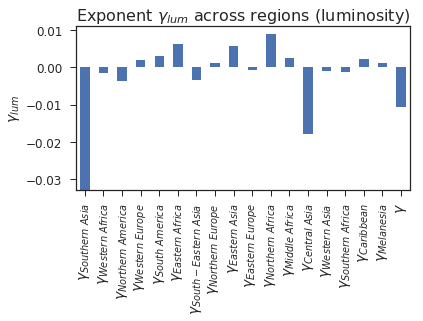

In [300]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

gamma_vars = [c for c in coefs_signif.index if 'd_' in c or c=='d']
gamma_coefs = coefs_signif[gamma_vars]
ax = gamma_coefs.plot(kind="bar", figsize=(6,3), fontsize=12)
_ = ax.set_xticklabels(["$\gamma_{%s}$"%(s.split("_")[1].replace(" ", " \ ") if "_" in s else "") 
                    for s in gamma_vars], fontsize=14)
ax.set_title("Exponent $\gamma_{lum}$ across regions (luminosity)", fontsize=16)
ax.set_ylabel("$\gamma_{lum}$", fontsize=14)

plt.savefig('../figures/benchmark_gamma_coefs.svg', format='svg', dpi=1200)
plt.show()


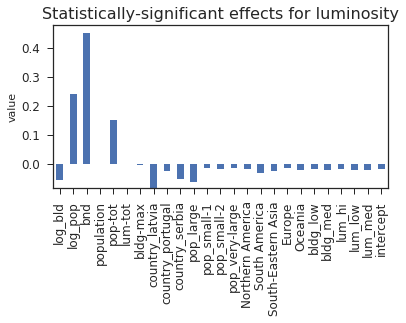

In [301]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

other_vars = [c for c in coefs_signif.index if c not in gamma_vars]
other_coefs = coefs_signif[other_vars]
ax = other_coefs.plot(kind="bar", figsize=(6,3), fontsize=12)
ax.set_title("Statistically-significant effects for luminosity", fontsize=16)
_ = ax.set_xticklabels([s.replace("subregion_", "").replace("region_", "").replace("scale-", "") for s in other_vars])
ax.set_ylabel("value")

### Build a tree-based regression model to benchmark profiles

The goal here is predictive power, as opposed to interpretability as above. 

In [302]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

In [303]:
# format features: vector regression case
N, D = Xbld_hat.shape
features_X = np.hstack([Xbld_hat_log, Xpop_hat_log, Xbnd])
features_S = pd.get_dummies(scales_df.drop("city", 1))
features = np.hstack([features_X, features_S.values])
feat_names = ["bld_%d"%i for i in range(D)] + \
            ["pop_%d"%i for i in range(D)] + \
            ["bnd_%d"%i for i in range(D)] + \
            features_S.columns.values.tolist()
target = Xlum_hat_log

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2)
print X_train.shape, X_test.shape, y_train.shape

(5548, 334) (1388, 334) (5548, 48)


In [305]:
# regmodel = MultiOutputRegressor(GradientBoostingRegressor(max_depth=20), n_jobs=-1)
# 0.155258665025

# regmodel = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
# 0.356485903159

regmodel = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, n_jobs=-1))
# 0.453858683607

# regmodel = MultiOutputRegressor(DecisionTreeRegressor(max_depth=12), n_jobs=-1)
# 0.0914787216912

# scores = cross_val_score(regmodel, features, target, cv=5)
# print np.mean(scores)

In [306]:
regmodel.fit(features, target)
y_pred = regmodel.predict(features)

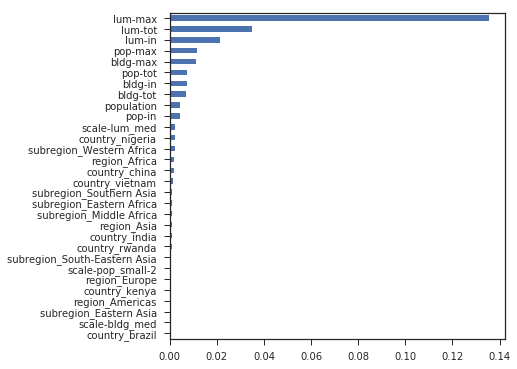

In [307]:
feat_imp_df = pd.DataFrame(np.vstack([regmodel.estimators_[i].feature_importances_ for i in range(D)]),
                           columns=feat_names)
feat_bldg = feat_imp_df.iloc[:,:D]
feat_pop = feat_imp_df.iloc[:,D:(2*D)]
feat_other = feat_imp_df.iloc[:,(3*D):].mean(0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6,6))
feat_other.head(30)[::-1].plot(kind="barh", ax=ax)

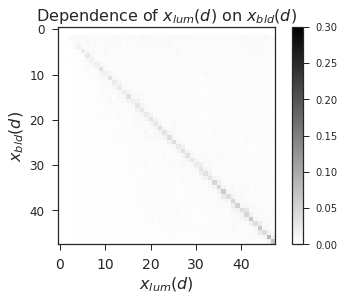

In [308]:
plt.imshow(feat_bldg, cmap=cm.gray_r, vmin=0, vmax=0.3)
plt.colorbar()
plt.title("Dependence of $x_{lum}(d)$ on $x_{bld}(d)$", fontsize=16)
plt.xlabel("$x_{lum}(d)$", fontsize=16)
plt.ylabel("$x_{bld}(d)$ ", fontsize=16)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=12)

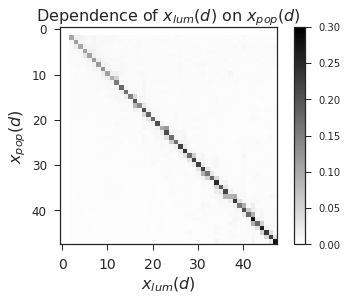

In [309]:
plt.imshow(feat_pop, cmap=cm.gray_r, vmin=0, vmax=0.3)
plt.colorbar()
plt.title("Dependence of $x_{lum}(d)$ on $x_{pop}(d)$", fontsize=16)
plt.xlabel("$x_{lum}(d)$", fontsize=16)
plt.ylabel("$x_{pop}(d)$ ", fontsize=16)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=12)

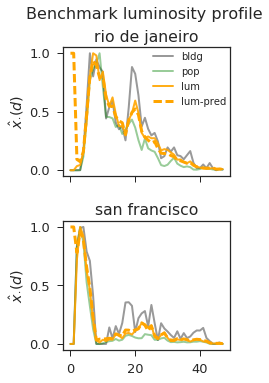

In [547]:
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.cm as cm

sns.set_context("notebook", font_scale=1.3)
fig, ax = plt.subplots(2,1, figsize=(3,7), 
                       gridspec_kw={"wspace":0.05, "hspace":0.35},
                       sharex=True, sharey=True)

mycities = [("rio de janeiro", "South America"),
            ("san francisco", "Northern America")]

for a,(j,(city, region)) in zip(ax.flatten(),enumerate(mycities)):
    idx = (scales_df.city==city) & (scales_df.subregion==region)
    mu_bld = Xbld_hat[idx,:].squeeze()
    mu_pop = Xpop_hat[idx,:].squeeze()
    mu_lum = Xlum_hat[idx,:].squeeze()
    mu_lum_pred = np.power(10,y_pred[idx,:].squeeze())
    
    # compute benchmark luminosity profile
    
    a.plot(distance_km, mu_bld, lw=2, color=colormap['bldg'], label="bldg", alpha=0.4)
    a.plot(distance_km, mu_pop, lw=2, color=colormap['pop'], label="pop", alpha=0.4)
    a.plot(distance_km, mu_lum, lw=2, color=colormap['lum'], label="lum", alpha=0.9)
    a.plot(distance_km, mu_lum_pred, lw=3, color=colormap['lum'], linestyle="--", label="lum-pred")
    a.set_title(city)
    if j in [2,3]: a.set_xlabel("$d \ [km]$")

ax[0].legend(loc="best", borderaxespad=0., fontsize=10)
ax[0].set_ylabel("$\hat x_{\cdot}(d)$")
ax[1].set_ylabel("$\hat x_{\cdot}(d)$")
fig.subplots_adjust(top=0.9)
fig.suptitle("Benchmark luminosity profile", fontsize=16)
fig.subplots_adjust(bottom=0.3)
fig.savefig('../figures/benchmark_profiles_examples.svg', 
            format='svg', dpi=1200, bbox_inches='tight')
fig.show()


In [330]:
discrepancy_bench = []
effort_emd_bench = []
for i in range(Xbld_hat.shape[0]):
    mu_lum = Xlum_hat[i,:]
    mu_lum_pred = np.power(10, y_pred[i,:])
    
    # compute normalized discrepancy
    dis_lum_tot, dis_lum_reg = compute_discrepancy(mu_lum, mu_lum_pred)
    dis_lum_tot_in, dis_lum_reg_in = compute_discrepancy(mu_lum, mu_pop, weights=mu_bnd)
    discrepancy_bench.append([dis_lum_tot, dis_lum_tot_in])
    
    # compute EMD effort
    emd_lum = compute_effort_emd(mu_lum, mu_lum_pred)
    emd_lum_in = compute_effort_emd(mu_lum, mu_lum_pred, weights=mu_bnd)
    effort_emd_bench.append([emd_lum, emd_lum_in])
    
effort_emd_bench = pd.DataFrame(np.array(effort_emd_bench), columns=["lum", "lum-in"])
effort_emd_bench = pd.concat([info_df, effort_emd_bench], axis=1)
discrepancy_bench = pd.DataFrame(np.array(discrepancy_bench), columns=["lum", "lum-in"])
discrepancy_bench = pd.concat([info_df, discrepancy_bench], axis=1)

brazzaville -0.688715543084 -0.867597298887
casablanca -0.645761318868 -0.439191732103
san francisco 0.0396111798981 -1.46514863918
rio de janeiro -0.101871128853 -1.46982057521
mumbai city 0.0108136000103 -1.44087510183
shanghai 0.0199609818614 -1.30486590159
paris -0.124631257019 -1.4551200708
barcelona -0.0977672297195 -1.51156844307


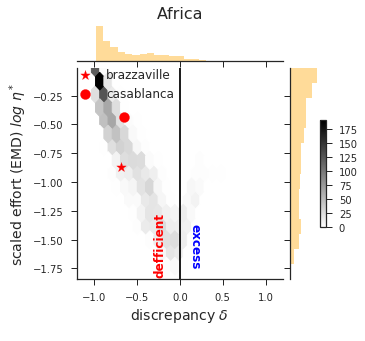

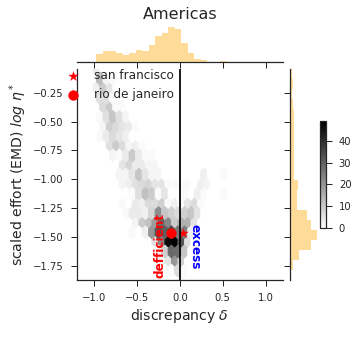

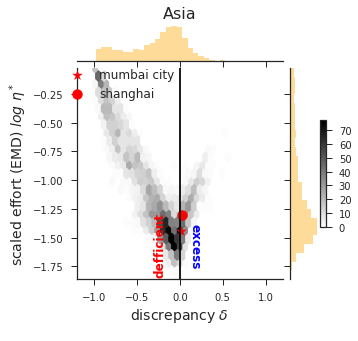

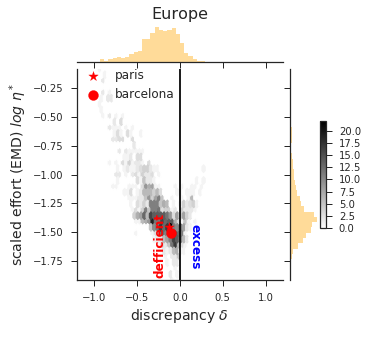

In [588]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

cities_region = {
    "Africa":["brazzaville", 'casablanca'],
    "Americas":["san francisco", "rio de janeiro"],
    "Asia":["mumbai city", "shanghai"],
    "Europe":['paris', 'barcelona']
}

for src in ["lum"]:
    for r in ['Africa', 'Americas', 'Asia', 'Europe']:
        idx = info_df['region']==r
        pop = scales_df['pop-max'][idx].astype(float)
        scl = scales_df['%s-max'%src][idx].astype(float)
        emd = effort_emd_bench["%s"%src][idx]
        eta = np.log10(emd) # *scl*pop)
        eta[np.isinf(eta) | np.isneginf(eta)] = 0
        delta = discrepancy_bench["%s"%src][idx]
        delta[np.isinf(delta)] = 0
        g = sns.jointplot(delta, eta, 
                          kind="hex", color=colormap[src], size=4.5, stat_func=None,
                          xlim=(-1.2,1.2), 
                          # ylim=(-100,1200), 
                          cmap=cm.gray_r)
        g.ax_joint.set_xlabel("discrepancy $\delta$", fontsize=14)
        g.ax_joint.set_ylabel("scaled effort (EMD) $log \ \eta^*$", fontsize=14)
        g.ax_marg_x.set_title(r, fontsize=16)
        g.ax_joint.axvline(x=0, color=colormap["bldg"])
        g.ax_joint.annotate("defficient", xy=(-0.3, 0.5+min(eta)), color="red", 
                            weight='bold', rotation=90)
        g.ax_joint.annotate("excess", xy=(0.1, 0.4+min(eta)), color="blue", 
                            weight='bold', rotation=-90)
        g.ax_joint.annotate(src, xy=(1.4, 0.5+min(eta)*1.1), fontsize=14,
                            weight='bold') 
                            #color=colormap[src])
        for c,m in zip(cities_region[r], ["*", 'o']):
            idx_c = (info_df['city']==c) & (info_df['region']==r)
            x,y = delta[idx_c].iloc[0], eta[idx_c].iloc[0]
            print c, x, y
            g.ax_joint.scatter(x, y, label=c, marker=m, s=100, color='red')
        g.ax_joint.legend(loc="best", bbox_to_anchor=(0.525, 1.05), fontsize=12)
        plt.colorbar()
        g.fig.show()
        
        g.fig.savefig('../figures/benchmark_density_discrepancy_effort_%s_%s.svg' % (src, r), 
                    format='svg', dpi=1200, bbox_inches='tight')


In [574]:
idx = (discrepancy_bench['lum']<0)
tmp_dis = discrepancy_bench[idx]
tmp_emd = effort_emd_bench[idx]
tmp_emd[(tmp_dis.lum>-0.7) & (tmp_dis.lum<-0.50) & \
        (tmp_dis['scale-pop'].isin(["very-large", "large"])) & \
        (tmp_dis.region=='Africa')]


,city,country,population,scale-pop,subregion,region,lum,lum-in
72,casablanca,morocco,3277246,large,Northern Africa,Africa,0.363754,0.336092
1131,brazzaville,republic of congo,1304964,large,Middle Africa,Africa,0.135645,0.099497
1154,nassaraw,nigeria,1003201,large,Western Africa,Africa,0.093371,0.058190
2517,conakry,guinea,1666245,large,Western Africa,Africa,0.220191,0.205130
2521,greater monrovia,liberia,1078595,large,Western Africa,Africa,0.232913,0.215989
3582,sidama,ethiopia,3914106,large,Eastern Africa,Africa,0.169997,0.143457


In [572]:
tmp_dis[(tmp_dis.lum>-0.7) & (tmp_dis.lum<-0.50) & \
        (tmp_dis['scale-pop'].isin(["very-large", "large"])) & \
        (tmp_dis.region=='Africa')]


,city,country,population,scale-pop,subregion,region,lum,lum-in
72,casablanca,morocco,3277246,large,Northern Africa,Africa,-0.645761,0.964116
1131,brazzaville,republic of congo,1304964,large,Middle Africa,Africa,-0.688716,-0.396531
1154,nassaraw,nigeria,1003201,large,Western Africa,Africa,-0.636556,-0.475255
2517,conakry,guinea,1666245,large,Western Africa,Africa,-0.691659,-0.048425
2521,greater monrovia,liberia,1078595,large,Western Africa,Africa,-0.614670,0.437208
3582,sidama,ethiopia,3914106,large,Eastern Africa,Africa,-0.641871,-0.066386


In [580]:
c

('brazaville', 'republic of congo')

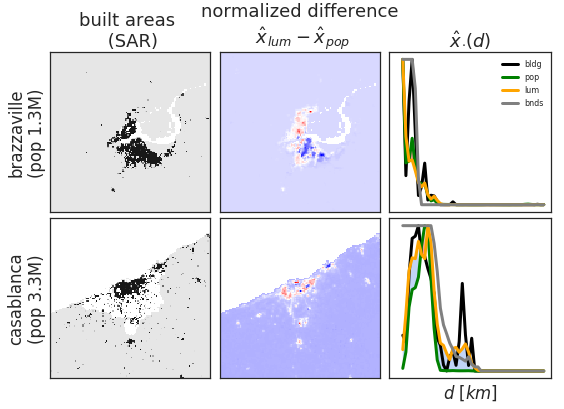

In [603]:
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec


nimg = 3
nrow = 2

mycities = [("brazzaville", "republic of congo"), 
#             ("rio de janeiro", "brazil"), 
#             ("san francisco", "united states"), 
#             ("barcelona", "spain"),
#             ("mumbai city", "india"), 
            ("casablanca", "morocco")]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(9,6))
gs1 = gridspec.GridSpec(nrow,nimg)
gs1.update(wspace=0.05, hspace=0.04) # set the spacing between axes. 

for i,c in enumerate(mycities):
    r = scales_df[(scales_df.city == c[0]) & (scales_df.country==c[1])].iloc[0]
    img = get_image_data((r['city'], r['country'], r['population']))
    bounds_mask = img['bnd']
    city_pop = r['population']
    cityname = c[0]
    
    city,smpl_name = cities_smpl[c[0]]
    mu_pop = city['profiles']['pop'][0]
    mu_pop = mu_pop/mu_pop.max()
    mu_lum = city['profiles']['lum'][0]
    mu_lum = mu_lum/mu_lum.max()
    mu_bnd = city['profiles']['bnds'][0]
    
    # compute discrepancy
    dis_lum, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)

    # plot built areas
    ax0 = plt.subplot(gs1[i,0]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(img['bldg'], bounds_mask>0, ax0, cmap="gray_r"); ax0.set_title("built areas \n (SAR)") if i==0 else None
#     # plot Nightlights
#     ax1 = plt.subplot(gs1[1,i]); ax1.set_xticks([]); ax1.set_yticks([])
#     ax1.imshow(img['lum'], cmap="copper"); ax1.set_ylabel("nightlights \n (VIIRS)") if i==0 else None
#     # plot population
#     ax2 = plt.subplot(gs1[2,i]); ax2.set_xticks([]); ax2.set_yticks([])
#     ax2.imshow(img['pop'],cmap="Greens"); ax2.set_ylabel("population \n (LandScan)") if i==0 else None
    ax0.set_ylabel("%s\n(pop %s)"%(cityname, format_pop(city_pop)))
    
    # plot difference lum - pop
    ax4 = plt.subplot(gs1[i,1]); ax4.set_xticks([]); ax4.set_yticks([])
    ax4.imshow(img['lum']/float(np.nanmax(img['lum']))-img['pop']/float(np.nanmax(img['pop'])),
               cmap="bwr"); 
    ax4.set_title("normalized difference\n $\hat x_{lum}-\hat x_{pop}$") if i==0 else None
    
    # plot profiles
    ax3 = plt.subplot(gs1[i,2]); ax3.set_xticks([]); ax3.set_yticks([])
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = city['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        ax3.plot(distance_km[2:], mu / scale, lw=3, label=s, color=colormap[s])
    if i == 0:
        ax3.set_title("$\hat x_{\cdot}(d)$")
        ax3.legend(loc="best", prop={'size': 8})
    ax3.set_xlabel("$d \ [km]$")    
    
    for p,q,d in dis_lum_reg:
        ax3.fill_between(distance_km[p:q], mu_lum[p:q], mu_pop[p:q], 
                             facecolor="red" if d<0 else "cornflowerblue",
                             interpolate=True, alpha=0.4)
fig.savefig('../figures/paper_figure_2.svg', 
            format='svg', dpi=1200, bbox_inches='tight')
fig.show()


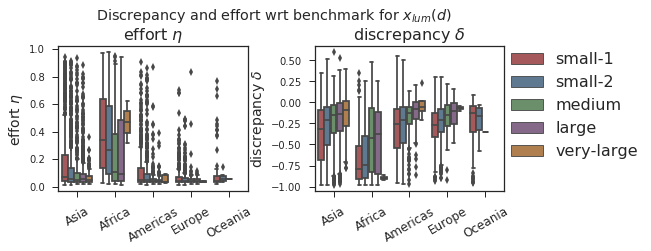

In [549]:
sns.set_context("notebook", font_scale=3)
sns.set(style="ticks")

fig, ax = plt.subplots(1,2, figsize=(8,3), 
                       gridspec_kw={"wspace":0.35, "hspace":0.1},
                       sharex=True, sharey=False)

sns.boxplot(x="region", y='lum', hue="scale-pop", palette=pop_colors,
            data=effort_emd_bench, ax=ax[0], hue_order=pop_scales)
ax[0].set_xlabel(""); ax[0].set_ylabel(""); 
# ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=12)
ax[0].set_title("effort $\eta$", fontsize=16) 
ax[0].set_ylabel("effort $\eta$", fontsize=14)
ax[0].legend_.remove()

sns.boxplot(x="region", y='lum', hue="scale-pop", palette=pop_colors,
            data=discrepancy_bench, ax=ax[1], hue_order=pop_scales)
ax[1].set_xlabel(""); ax[1].set_ylabel(""); 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, fontsize=12)
# ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=12)
ax[1].set_title("discrepancy $\delta$", fontsize=16)
ax[1].set_ylabel("discrepancy $\delta$", fontsize=14)
ax[1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))

fig.subplots_adjust(top=0.8)
fig.suptitle("Discrepancy and effort wrt benchmark for $x_{lum}(d)$")

fig.savefig('../figures/benchmark_discrepancy_effort_distribution.svg', 
            format='svg', dpi=1200, bbox_inches='tight')


#### Plot geographical distribution of effort/discrepancy

In [344]:
cityinfo_df = cities_sel_df[['city', "country", "population", 'location', "subregion"]].copy()
cityinfo_df['population'] = cityinfo_df['population'].astype(int)

discrepancy['population'] = discrepancy['population'].apply(lambda x: int(float(x)))
discrepancy_gdf = gpd.GeoDataFrame(pd.merge(discrepancy, cityinfo_df, 
                                   on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
effort_emd['population'] = effort_emd['population'].apply(lambda x: int(float(x)))
effort_emd_gdf = gpd.GeoDataFrame(pd.merge(effort_emd, cityinfo_df, 
                                    on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
discrepancy_bench['population'] = discrepancy_bench['population'].apply(lambda x: int(float(x)))
discrepancy_bench_gdf = gpd.GeoDataFrame(pd.merge(discrepancy_bench, cityinfo_df, 
                                   on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
effort_emd_bench['population'] = effort_emd_bench['population'].apply(lambda x: int(float(x)))
effort_emd_bench_gdf = gpd.GeoDataFrame(pd.merge(effort_emd_bench, cityinfo_df, 
                                    on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
print discrepancy_gdf.shape, effort_emd_gdf.shape


(6936, 13) (6936, 13)


In [345]:
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis/")
from normalized_colorbar import shiftedColorMap
from scipy import stats

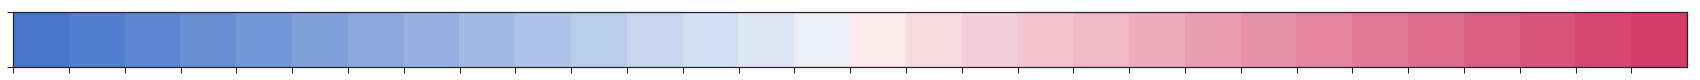

In [346]:
sns.palplot(sns.diverging_palette(255, 0, sep=5, n=30))

In [347]:
def plot_map(gdf, column="lum", title=""):
    sns.set_context("notebook", font_scale=2)
    sns.set(style="ticks", font_scale=2)

    # create a suitable colormap for display
    vmin = np.percentile(gdf[column], 0.0)
    vmax = np.percentile(gdf[column], 100)
    pct_zero = 1 - vmax/(vmax + abs(vmin)) 
    cmap_geo = sns.diverging_palette(255, 0, sep=5, n=30, as_cmap=True)
    cmap_geo = shiftedColorMap(cmap_geo, name='shiftedcmap_dis',
                               start=0.0, midpoint=pct_zero, stop=1.0)

    # plot the world map
    fig, ax = plt.subplots(figsize=(18,8))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(ax=ax, 
                    color=[0.99,0.99,0.8,0.1], 
                    edgecolor=[0.8,0.8,0.8,0.9])

    # plot cities
    gdf.plot(ax=ax, marker='.', markersize=7, alpha=0.9, 
                 column=column, cmap=cmap_geo)
    ax.set_title(title)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

    # add color bar
    cax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmap_geo, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)    

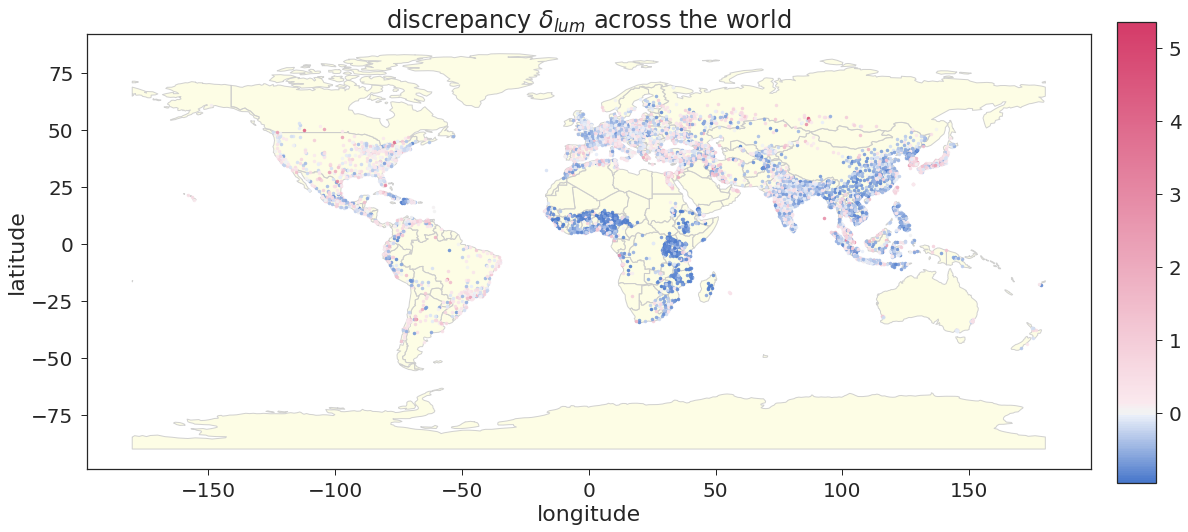

In [348]:
plot_map(discrepancy_gdf, column="lum", 
         title="discrepancy $\delta_{lum}$ across the world")
plt.savefig('../figures/discrepancy_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

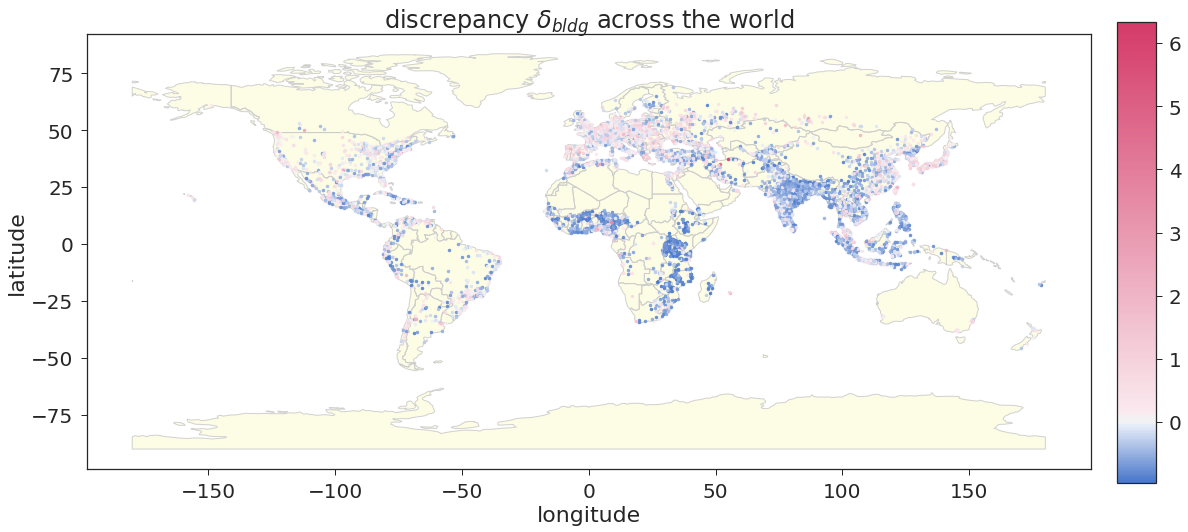

In [349]:
plot_map(discrepancy_gdf, column="bldg", 
         title="discrepancy $\delta_{bldg}$ across the world")
plt.savefig('../figures/discrepancy_bldg.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

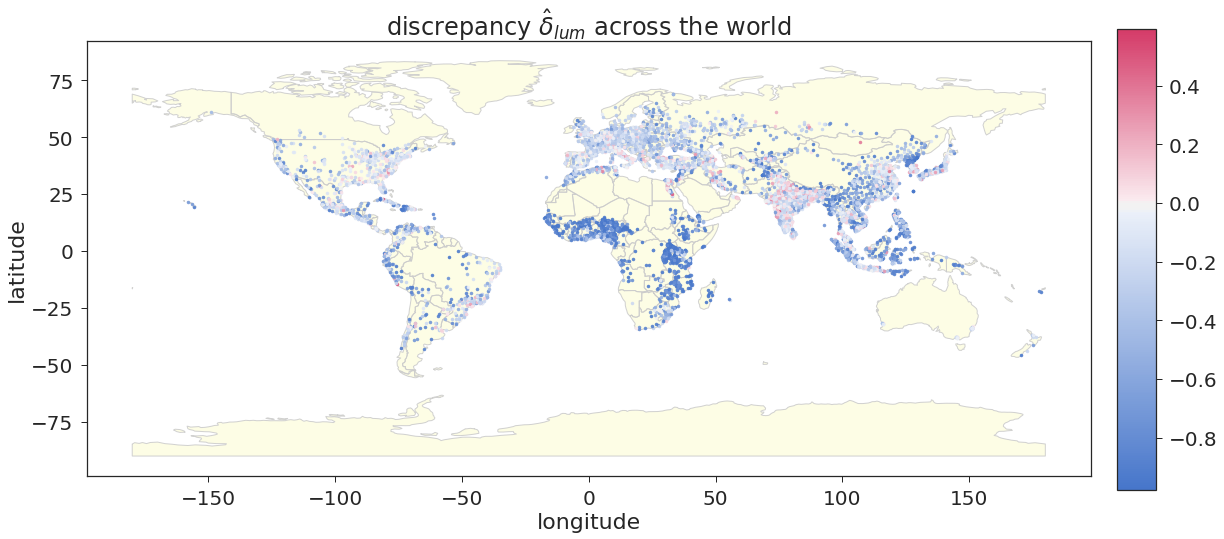

In [350]:
plot_map(discrepancy_bench_gdf, column="lum", 
         title="discrepancy $\hat \delta_{lum}$ across the world")
plt.savefig('../figures/benchmark_discrepancy_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

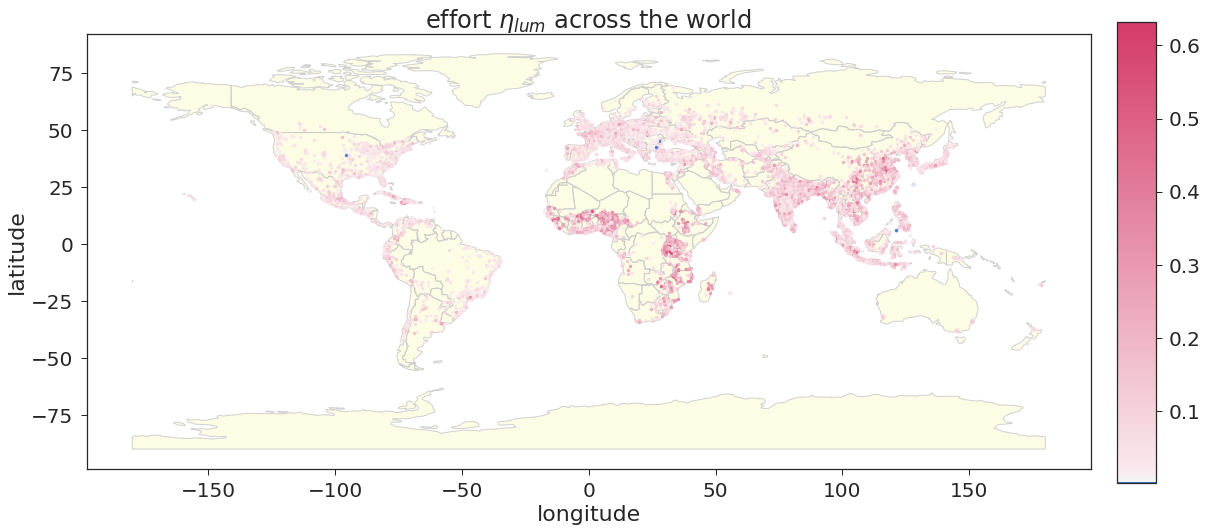

In [351]:
plot_map(effort_emd_gdf, column="lum", 
         title="effort $\eta_{lum}$ across the world")
plt.savefig('../figures/effort_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

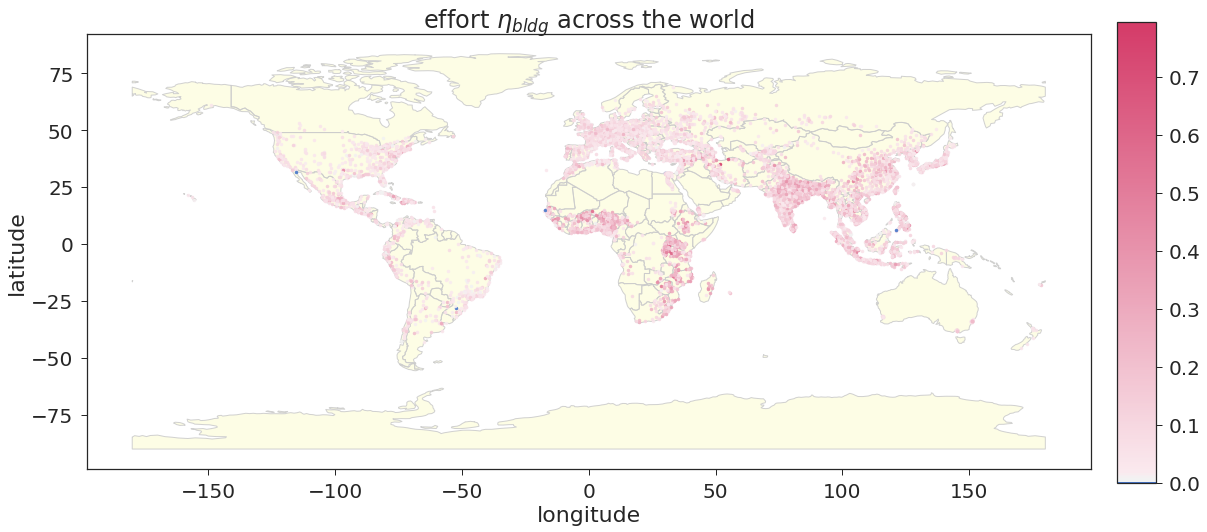

In [352]:
plot_map(effort_emd_gdf, column="bldg", 
         title="effort $\eta_{bldg}$ across the world")
plt.savefig('../figures/effort_bldg.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

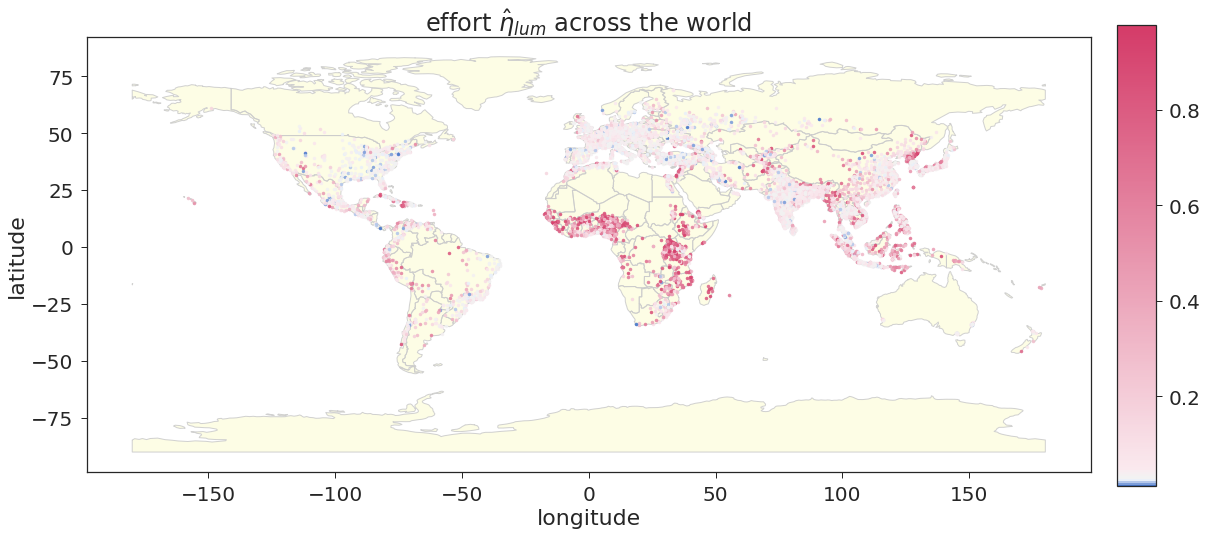

In [353]:
plot_map(effort_emd_bench_gdf, column="lum", 
         title="effort $\hat \eta_{lum}$ across the world")
plt.savefig('../figures/benchmark_effort_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

# Scaling of discrepancy/effort with total population/built area/luminosity

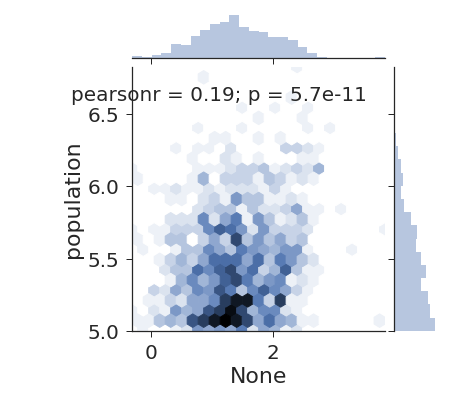

In [354]:
effort_hat = effort_emd_bench['lum'] * scales_df['pop-max'] # * scales_df['lum-max']

sns.jointplot(np.log10(effort_hat[info_df['region']=='Europe']), 
              np.log10(info_df[info_df['region']=='Europe']['population'].astype(float)), kind='hex')

In [355]:
from scipy import stats

def compute_loglog_fit(cur_var):
    q1, q99 = np.percentile(cur_var, [1,99])
    bins = np.logspace(np.log10(q1), np.log10(q99), 20, base=10)
    N_counts, var = np.histogram(cur_var, bins=bins)
    prob_bins= N_counts / float(N_counts.sum()) + 1e-4
    a, b, R, p, s = stats.linregress(np.log10(bins[:-1]), np.log10(prob_bins))
    prob_fit = b + a * np.log10(bins)
    prob_fit = np.power(10, prob_fit)
    return (bins, prob_bins), (prob_fit, a*np.log(10), p, s)

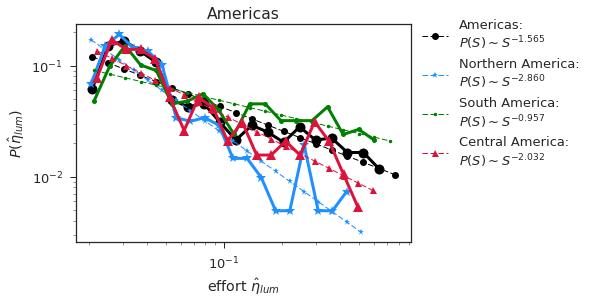

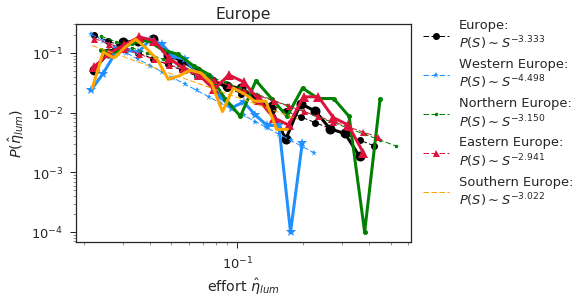

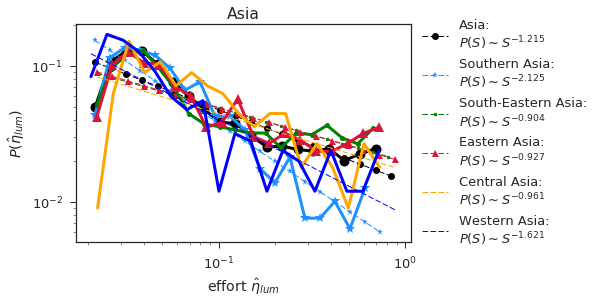

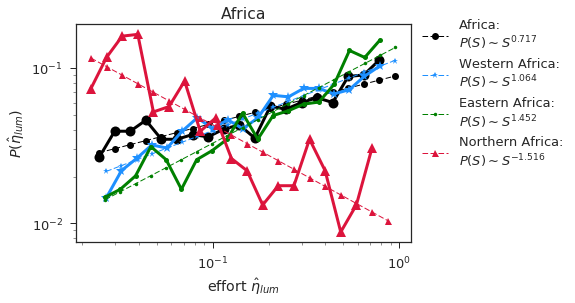

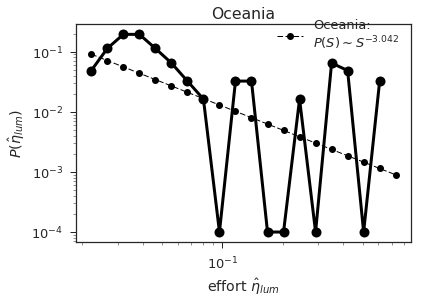

In [356]:
t = 0.02
field = 'lum'
my_gdf = effort_emd_bench

regions = ['Americas', 'Europe', 'Asia', 'Africa', 'Oceania']
colors = ["dodgerblue", "green", "crimson", "orange", "blue"]
markers= ["*", '.', '^', '|', 'x', '4']

sns.set_context("notebook", font_scale=1.3)

for region in regions:
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    cur_gdf = my_gdf[(my_gdf.region==region)]
    cur_pop = cur_gdf['population'].values
    cur_var = cur_gdf[field].values
    cur_var = cur_var[cur_var>t]

    (bins, prob_bins), (prob_fit, a, p, s) = compute_loglog_fit(cur_var)
    d, = ax.loglog(bins[:-1], prob_bins, marker='o', lw=3, markersize=10, label=region, color='k')
    f, = ax.loglog(bins, prob_fit, label="%s:\n$P(S)\sim S^{%2.3f}$"%(region,a), lw=1, linestyle="--", color='k', marker='o')

    mylegend = [f]
    subregions = my_gdf[my_gdf.region==region].subregion.unique()
    for subreg,color,marker in zip(subregions, colors, markers):
        cur_gdf  = my_gdf[(my_gdf.region==region) & (my_gdf.subregion==subreg)]
        cur_pop = cur_gdf['population'].values
        cur_var = cur_gdf[field].values
        cur_var = cur_var[cur_var>t]
        if len(cur_var)<100:
            continue
        (bins, prob_bins), (prob_fit, a, p, s) = compute_loglog_fit(cur_var)
        d, = ax.loglog(bins[:-1], prob_bins, marker=marker, lw=3, markersize=10, label=subreg, color=color)
        f, = ax.loglog(bins, prob_fit, label="%s:\n$P(S)\sim S^{%2.3f}$"%(subreg,a), lw=1, linestyle="--", color=color, marker=marker)
        mylegend += [f]

    ax.set_xlabel("effort $\hat \eta_{lum}$")
    ax.set_ylabel("$P(\hat \eta_{lum})$")
    ax.set_title(region)
    data_legend = ax.legend(handles=mylegend, loc='best', ncol=1, 
                            bbox_to_anchor=(1., 1.08))



# Cluster cities by spatial profiles

The examples above invite the following questions:
* can we identify "classes" of cities by their general macroeconomic urban form (population density, built area density, luminosity), as described by the average profiles $\hat{x}_\cdot (d)$?
* how do we model the large amount of variance around these profiles observed in the real data? In particular, can we arrive at a 'functional' model that can, in practice, emulate the real data without the need of complex modeling assumptions?

### Compute classes of profiles

For this, we stack all the normalized profiles $\hat x_{\cdot}(d)$ in one matrix that we cluster via K-Means. We find the 'optimal' number of classes via the gap statistic.

In [359]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from math import sqrt, log

# returns series of random values sampled between min and max values of passed col
def get_rand_data(col):
	rng = col.max() - col.min()
	return pd.Series(random_sample(len(col))*rng + col.min())

def iter_kmeans(df, n_clusters, num_iters=10):
    rng =  range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, batch_size=1000)
        k.fit(df)
        vals[i] = k.inertia_
    return vals

def gap_statistic(df, max_k=10):
    gaps = pd.Series(index = range(1, max_k + 1))
    for k in range(1, max_k + 1):
        print k,
        km_act = MiniBatchKMeans(n_clusters=k, n_init=10, batch_size=1000)
        km_act.fit(df)

        # get ref dataset
        ref = df.apply(get_rand_data)
        ref_inertia = iter_kmeans(ref, n_clusters=k).mean()

        gap = log(ref_inertia - km_act.inertia_)
        gaps[k] = gap
    print "Done!"

    return gaps

In [ ]:
X = np.vstack([Xbld_hat, Xpop_hat, Xlum_hat])
print X.shape

In [ ]:
# gap statistic analysis to find optimum number of clusters

gaps = gap_statistic(pd.DataFrame(X), max_k=50)
K_star = np.argmax(gaps)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(gaps/gaps.max(), lw=3, label="gap statistic", color=colormap['all'])
plt.title("Optimum # clusters $K^*$")
plt.xlabel("# clusters K")
plt.ylabel("gap statistic")
plt.legend(loc="best")
plt.show()


In [360]:
from scipy.spatial.distance import cdist, pdist

def kmeans_var_expl(data, n):
    kMeansVar = [MiniBatchKMeans(n_clusters=k, batch_size=1000).fit(data) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss - wcss
    return tss, bss, wcss

In [361]:
tss, bss, wcss = kmeans_var_expl(X, 50)
var_expl = bss/tss

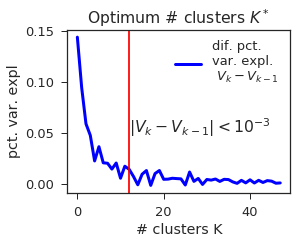

In [363]:
plt.figure(figsize=(4,3))
plt.plot(np.diff(var_expl), lw=3, label="dif. pct. \nvar. expl.\n $V_k-V_{k-1}$", color=colormap['all'])
plt.axvline(x=12, color='red')
plt.title("Optimum # clusters $K^*$")
plt.xlabel("# clusters K")
plt.ylabel("pct. var. expl")
plt.legend(loc="best")
plt.text(12, 0.05, "$|V_k-V_{k-1}|<10^{-3}$")
plt.savefig('../figures/profiles_kmeans_optimal_K.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [364]:
K_star = 12
mod = KMeans(n_clusters=K_star, n_init=10)
mod.fit(X)
centroids = mod.cluster_centers_

C = mod.predict(X)
C_bld = mod.predict(Xbld)
C_pop = mod.predict(Xpop)
C_lum = mod.predict(Xlum)

In [375]:
def plot_clusters(X, C, centroids, 
                  nrow=1, text="", figsize=(6,4), top=0.75,
                  xlabels=True):
    K = len(np.unique(C))
    clust_sizes = pd.Series(C).value_counts().values
    nx = nrow
    ny = K / nx
    fig, ax = plt.subplots(nx,ny, 
                           gridspec_kw={"wspace":0.15, "hspace":0.3},
                           figsize=figsize, sharex=True, sharey=True)
    if len(ax.shape)==1:
        ax = np.expand_dims(ax, axis=0)
    for k,a in zip(range(K), ax.flatten()):
        idx = np.where(C == k)[0]
        std = X[idx,:].std(0)
        cntr = centroids[k,:]
        cntr = cntr / cntr.max()
        a.fill_between(distance_km, cntr-std, cntr+std, 
           color=colormap[text], alpha=0.3)
        a.plot(distance_km, cntr, lw=5, color=colormap[text])
        a.set_ylim((0,1.1))
        # a.axis("off")
        a.set_title("C%d: %2.1f%%"%(k,100*float(clust_sizes[k])/clust_sizes.sum()))
        if k / ny == nx-1:
            if xlabels: a.set_xlabel("d [km]")
            a.set_xticks(distance_km[::6])
            a.set_xticklabels(distance_km[::6], rotation=30)
        if k % ny == 0:
            a.set_ylabel("$x_{\cdot}(d)$")

    fig.suptitle("Classes of normalized profiles $x_{\cdot}(d)$: centroids")
    fig.subplots_adjust(top=top)

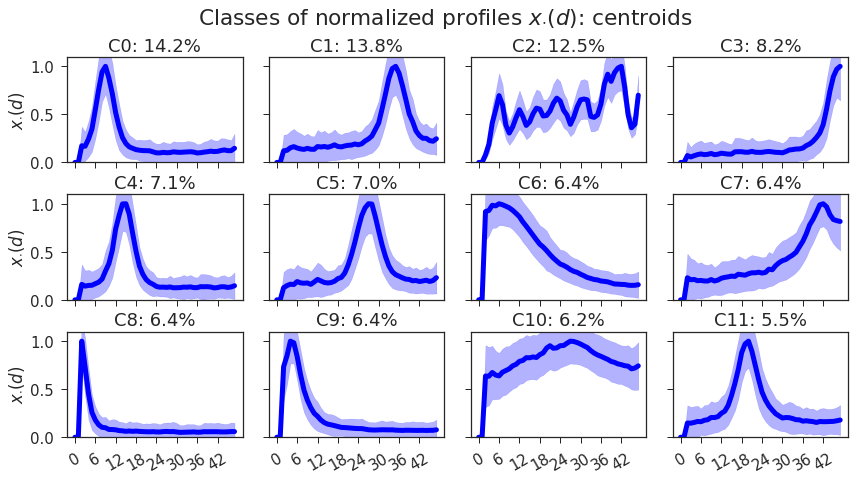

In [376]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(X, C, centroids, text="all", 
              nrow=3, figsize=(14,7), top=0.88, xlabels=False)

plt.savefig('../figures/profiles_kmeans.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [377]:
clust_df = pd.concat([info_df, 
                      pd.DataFrame(np.vstack([C_bld, C_pop, C_lum]).T, 
                                   columns=["bldg", "pop", "lum"])], axis=1)
clust_df['pattern'] = map(lambda x,y,z: "bldg:%s; pop:%s; lum:%s"%(x,y,z), clust_df["bldg"], clust_df["pop"], clust_df["lum"])
clust_df.head()

,city,country,population,scale-pop,subregion,region,bldg,pop,lum,pattern
0,shahdol,india,1237432,large,Southern Asia,Asia,2,10,2,bldg:2; pop:10; lum:2
1,lafia,nigeria,364173,small-2,Western Africa,Africa,2,10,2,bldg:2; pop:10; lum:2
2,ibarapa central,nigeria,120329,small-1,Western Africa,Africa,2,10,2,bldg:2; pop:10; lum:2
3,hamilton,united states,360445,small-2,Northern America,Americas,2,6,6,bldg:2; pop:6; lum:6
4,purnia,india,3385281,large,Southern Asia,Asia,2,10,10,bldg:2; pop:10; lum:10


##### How many different patterns are there in which cities "select" from these cluster centers?

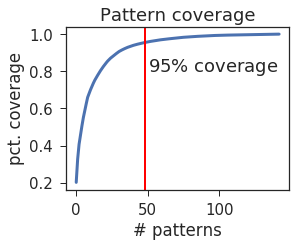

In [379]:
pattern_coverage = clust_df['pattern'].value_counts() / float(len(clust_df))

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(pattern_coverage.cumsum().values, lw=3)
ax.set_title("Pattern coverage")
ax.set_xlabel("# patterns")
ax.set_ylabel("pct. coverage")
ax.axvline(x=48, lw=2, color="red")
ax.text(50, 0.8, "$95\%$ coverage")

plt.savefig('../figures/patterns_profiles_coverage.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

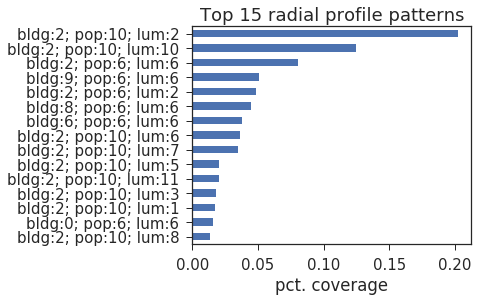

In [381]:
pattern_coverage.head(15)[::-1].plot(kind='barh', figsize=(5,4))
plt.title("Top 15 radial profile patterns")
plt.xlabel("pct. coverage")

plt.savefig('../figures/top_patterns.svg', format='svg', dpi=1200, bbox_inches='tight')

##### Define a "cost matrix" via EMD between cluster centroids

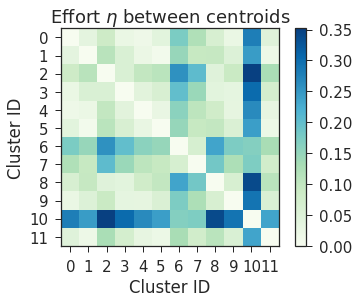

In [383]:
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import squareform

centr_cost_emd = pairwise_distances(centroids, metric = wasserstein_distance)

plt.imshow(centr_cost_emd, cmap=cm.GnBu)
plt.colorbar()
plt.title("Effort $\eta$ between centroids")
plt.xlabel("Cluster ID")
plt.ylabel("Cluster ID")
_ = plt.xticks(range(K_star))
_ = plt.yticks(range(K_star))

plt.savefig('../figures/cost_matrix_profiles.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [397]:
pattern_df = pd.DataFrame(pattern_coverage.values, index=pattern_coverage.index, 
                          columns=["coverage"])
pattern_df['eta_lum'] = map(lambda s: centr_cost_emd[int(s.split("; ")[2].split(":")[1]),int(s.split("; ")[1].split(":")[1])],
                            pattern_df.index)
pattern_df['eta_bldg'] = map(lambda s: centr_cost_emd[int(s.split("; ")[0].split(":")[1]),int(s.split("; ")[1].split(":")[1])],
                            pattern_df.index)
pattern_df.head()

,coverage,eta_lum,eta_bldg
bldg:2; pop:10; lum:2,0.202422,0.351979,0.351979
bldg:2; pop:10; lum:10,0.124856,0.000000,0.351979
bldg:2; pop:6; lum:6,0.080450,0.000000,0.258343
bldg:9; pop:6; lum:6,0.050461,0.000000,0.173752
bldg:2; pop:6; lum:2,0.048443,0.258343,0.258343


In [400]:
mycities = [("paris", "france"), 
            ("rio de janeiro", "brazil"), 
            ("san francisco", "united states"), 
            ("barcelona", "spain"),
            ("mumbai city", "india"), 
            ("shanghai", "china")]


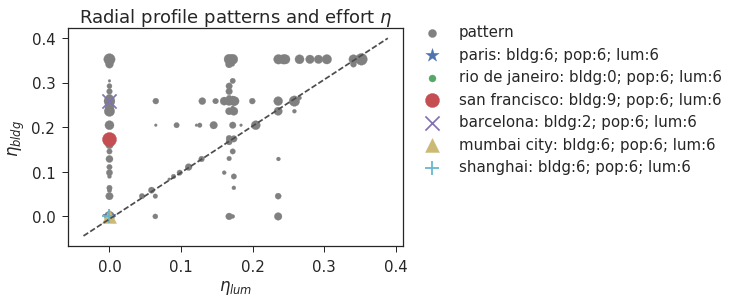

In [433]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pattern_df['eta_lum'], pattern_df['eta_bldg'], color="gray", 
            s = np.log(pattern_df['coverage']*5000)*20, label="pattern")
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_xlabel("$\eta_{lum}$")
ax.set_ylabel("$\eta_{bldg}$")
ax.set_title("Radial profile patterns and effort $\eta$")

markers = ["*", '.', 'o', 'x', '^', '+']
for m,c in zip(markers,mycities):
    r = clust_df[(clust_df.city==c[0]) & (clust_df.country==c[1])].iloc[0]
    s = "%s: bldg:%d; pop:%d; lum:%d" % (r['city'], r['bldg'], r['pop'], r['lum'])
    p = pattern_df.ix["bldg:%d; pop:%d; lum:%d"%(r['bldg'], r['pop'], r['lum'])]
    plt.scatter(p['eta_lum'], p['eta_bldg'], label=s, marker=m, s=200)   
plt.legend(loc="best", bbox_to_anchor=(1., 1.08))

plt.savefig('../figures/pattern_effort_bldg_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [435]:
r

city                      shanghai
country                      china
population                22469195
scale-pop               very-large
subregion             Eastern Asia
region                        Asia
bldg                             6
pop                              6
lum                              6
pattern       bldg:6; pop:6; lum:6
Name: 2255, dtype: object

In [438]:
(r['city'], r['country'], r['population'])

('shanghai', 'china', 22469195)

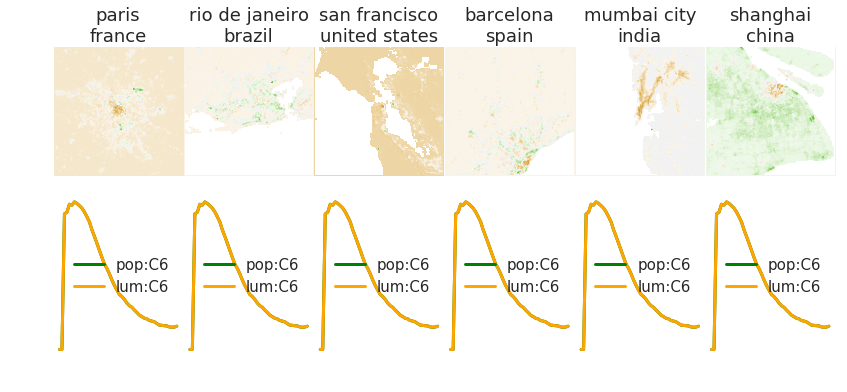

In [441]:
fig, ax = plt.subplots(2,len(mycities), figsize=(14,6), 
                        gridspec_kw={"wspace":0.01, "hspace":0.01})
for j,c in enumerate(mycities):
    r = clust_df[(clust_df.city==c[0]) & (clust_df.country==c[1])].iloc[0]
    
    # plot city map
    img = get_image_data((r['city'], r['country'], r['population']))
    s = "%s: bldg:%d; pop:%d; lum:%d" % (r['city'], r['bldg'], r['pop'], r['lum'])
    title = "%s\npop. %s"%(r['city'], format_pop(r['population']))
    ax[0,j].imshow(frame_image(img['lum'] - img['pop']), cmap=lum_cmap)
    ax[0,j].axis("off") 
    ax[0,j].set_title("%s\n%s"%(r['city'],r['country']))
    
    # plot profile patterns
    for src in ['pop', 'lum']:
        cntr = centroids[r[src],:]
        ax[1,j].plot(distance_km, cntr / cntr.max(), 
                     color=colormap[src], lw=3, label="%s:C%d"%(src,r[src]))
    ax[1,j].legend(loc="best")
    ax[1,j].axis("off")


### Illustrate examples in each city pattern

In [ ]:
clust_df['scale-bldg'] = scales_df['scale-bldg']
clust_df['scale-lum'] = scales_df['scale-lum']
clust_gdf = gpd.GeoDataFrame(pd.merge(clust_df, cityinfo_df, 
                                   on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
clust_gdf.head()

# SCRATCH

###  Compute city similarity graph for spectral clustering

##### Compute similarity graph for city scales and geographical regions

In [ ]:
def construct_scale_sim_matrix(scales_vec):
    N = len(scales_vec)
    S = np.zeros((N,N))
    for i in range(N):
        S[i,:] = [scales_vec[j]==scales_vec[i] for j in range(N)]
    return S

Sbld = construct_scale_sim_matrix(scales_df['scale-bldg'].values)
Spop = construct_scale_sim_matrix(scales_df['scale-pop'].values)
Slum = construct_scale_sim_matrix(scales_df['scale-lum'].values)
G = construct_scale_sim_matrix(scales_df['region'].values)

##### Compute similarity graph for profiles via EMD

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import squareform

EMDbld = pairwise_distances(Xbld_hat, metric = wasserstein_distance, n_jobs = -1)
EMDpop = pairwise_distances(Xpop_hat, metric = wasserstein_distance, n_jobs = -1)
EMDlum = pairwise_distances(Xlum_hat, metric = wasserstein_distance, n_jobs = -1)


##### Spectral clustering of cities

We construct the final similarity matrix between cities as :

$\displaystyle
\begin{align*}
W &= \sum_{s \in \{pop,lum,bldg\}} \alpha_s EMD_s - \sum_{s \in \{pop,lum,bldg\}} \beta_s S_s - \zeta G\\
W^* &= e^{-W} \ \text{transforms distance to similarity}
\end{align*}
$

In [ ]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.manifold import SpectralEmbedding

alpha = [1,1,1]
beta = [-1,-1,-1]
zeta = [-0.5]
W = np.zeros_like(EMDbld)
for Y,a in zip([EMDbld,EMDpop,EMDlum,Sbld,Spop,Slum,G], alpha + beta + zeta):
    W += -Y*a
W_star = np.exp(W - W.max())
eps = np.percentile(W_star.flatten(), 5)
W_star[W_star<eps] = 0

In [ ]:
plt.hist(W_star.flatten())

In [ ]:
plt.imshow(W_star)

In [ ]:
# cluster similarity matrix
K = 12
mod = SpectralClustering(n_clusters=K,
                         eigen_solver='arpack', n_jobs=-1, 
                         affinity="precomputed")
C = mod.fit_predict(W_star)
lambdas = mod.eigenvalues_
centr_bld = np.array([Xbld_hat[C==c].mean(0) for c in range(K)])
centr_pop = np.array([Xpop_hat[C==c].mean(0) for c in range(K)])
centr_lum = np.array([Xlum_hat[C==c].mean(0) for c in range(K)])

In [ ]:
pd.crosstab(C, scales_df['scale-pop']).T

In [ ]:
plt.plot(np.abs(lambdas[1:-1] - lambdas[:-2]))

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(np.arange(1,len(lambdas[:-1])), np.diff(lambdas[:-1]), label="tot", color=colormap['all'])


In [ ]:
def plot_clusters(X, C, centroids, 
                  nrow=1, text="", figsize=(6,4), top=0.75,
                  xlabels=True):
    K = len(np.unique(C))
    clust_sizes = pd.Series(C).value_counts().values
    nx = nrow
    ny = K / nx
    fig, ax = plt.subplots(nx,ny, 
                           gridspec_kw={"wspace":0.15, "hspace":0.3},
                           figsize=figsize, sharex=True, sharey=True)
    if len(ax.shape)==1:
        ax = np.expand_dims(ax, axis=0)
    for k,a in zip(range(K), ax.flatten()):
        idx = np.where(C == k)[0]
        std = X[idx,:].std(0)
        a.fill_between(distance_km,
           centroids[k,:]-std, 
           centroids[k,:]+std, 
           color=colormap[text], alpha=0.3)
        a.plot(distance_km, centroids[k,:], lw=5, color=colormap[text])
        # a.axis("off")
        a.set_title("C%d: %2.1f%%"%(k,100*float(clust_sizes[k])/clust_sizes.sum()))
        if k / ny == nx-1:
            if xlabels: a.set_xlabel("d [km]")
            a.set_xticks(distance_km[::6])
            a.set_xticklabels(distance_km[::6], rotation=30)
        if k % ny == 0:
            a.set_ylabel("log $x_{\cdot}(d)$")

    plt.suptitle("Clustering cities by $x_{%s}(d)$"%text)
    fig.subplots_adjust(top=top)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(Xbld_hat, C, centr_bld, text="bldg", 
              nrow=3, figsize=(12,10), top=0.9, xlabels=False)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(Xlum_hat, C, centr_lum, text="lum", 
              nrow=3, figsize=(14,10), top=0.9, xlabels=False)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

clust_dist = pd.Series(C.astype(int)).value_counts()/float(len(C))
clust_dist.plot(kind="bar", figsize=(8,3))
plt.title("Groups of cities by $\hat x_{%s}(d)$"%"+".join(["pop","bld","lum"]))
plt.xlabel("Spatial profile cluster")
plt.ylabel("pct. cities")

In [ ]:
nx = 3
ny = 4

sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(nx,ny, gridspec_kw={"wspace":0.03, "hspace":0.55},
                       figsize=(12,9), sharex=True, sharey=True)

for k,a in enumerate(ax.flatten()):
    # plot building centroid
    idx = np.where(C == k)[0]
    std = Xbld_hat[idx,:].std(0)
    a.plot(distance_km, centr_bld[k,:], lw=3, color=colormap['bldg'], 
           label="bld: C%d"%k)
    a.fill_between(distance_km,
                   centr_bld[k,:]-std, 
                   centr_bld[k,:]+std, 
                   color=colormap['bldg'], alpha=0.3)
    # plot population centroid
    std = Xpop_hat[idx,:].std(0)
    a.plot(distance_km, centr_pop[k,:], lw=3, color=colormap['pop'], 
           label="pop: C%d"%k)
    a.fill_between(distance_km,
                   centr_pop[k,:]-std, 
                   centr_pop[k,:]+std, 
                   color=colormap['pop'], alpha=0.3)
    # plot luminosity centroid
    std = Xlum_hat[idx,:].std(0)
    a.plot(distance_km, centr_lum[k,:], lw=3, color=colormap['lum'], 
           label="lum: C%d"%k)
    a.fill_between(distance_km,
                   centr_lum[k,:]-std, 
                   centr_lum[k,:]+std, 
                   color=colormap['lum'], alpha=0.3)
    # a.axis("off")
    a.set_title("C%d: %2.1f%%\n"%(k,clust_dist.ix[k]))
    if k / ny == nx-1:
        a.set_xlabel("d [km]")
        a.set_xticks(distance_km[::6])
        a.set_xticklabels(distance_km[::6], rotation=30)
    if k % ny == 0:
        a.set_ylabel("log $\hat x_{\cdot}(d)$")

    # a.legend(loc="best")
        
plt.suptitle("City clusters by log $\hat x_{bld,pop,lum}(d)$")
fig.subplots_adjust(top=0.85)
plt.show()


#### Read in all image source paths

#### Make example canvass to plot for each 

In [ ]:
from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = (img - img.min()) / float((img.max() - img.min()))
    return img


In [ ]:
def make_canvass(image_paths, labels, nExamples=10, thumbSize = (64,64,3), pad_pix=2, title="example"):
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.ones(((thumbSize[0]+pad_pix)*nClusters, nExamples*(thumbSize[1]+pad_pix), 3))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = concat_sources(image_paths[idx[j]])
            img = resize(img, thumbSize, preserve_range=True)
            canvas[i*(thumbSize[0]+pad_pix):(i*pad_pix + (i+1)*thumbSize[0]), 
                   j*(thumbSize[1]+pad_pix):(j*pad_pix + (j+1)*thumbSize[1])] = img
    return canvas

In [ ]:
canvas = make_canvass(sources.values(), 
                      [city2clust_all[x] for x in sources.keys()])

In [ ]:
nClusters = len(np.unique(C_all))

# plot examples of each class
fig,ax = plt.subplots(1, figsize=(12,10))
plt.tight_layout()
print canvas.shape
ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
ax.set_title("Classes of cities: examples", fontsize=18)
ax.set_ylabel("-- examples --", fontsize=16)
ax.set_xlabel("-- classes --", fontsize=16)
# Turn off tick labels
ax.set_xticks([64 * (0.5 + x*1.03) + 2 for x in range(nClusters)])
ax.set_xticklabels(["C%d"%x for x in range(nClusters)], fontsize=16, rotation=90)
ax.set_yticklabels([])
# plt.axis("off")
plt.show()

#### Geographical distribution of clusters

In [ ]:
cities_gdf = gpd.GeoDataFrame(cities_sel_df)
#cities_gdf['geometry'] = cities_gdf['geometry'].apply(lambda s: shapely.wkt.loads(s))
cities_gdf['cluster'] = cities_gdf['City'].apply(lambda x: int(city2clust_all[x]) if x in city2clust_all else np.nan)
# cities_gdf.dropna(inplace=True)

In [ ]:
sns.set_context('notebook', font_scale=1.5)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(3,4,gridspec_kw={"wspace":0.03, "hspace":0.03},
                           figsize=(16,7), sharex=True, sharey=True)
for c,a in zip(range(len(set(C_all))), ax.flatten()):
    world.plot(ax=a, color=[0.9,0.9,0.9,0.2], edgecolor=[0.8,0.8,0.8,0.9])
    cur_gdf = cities_gdf[cities_gdf['cluster']==c].sort_values("Population", ascending=False)
    cur_gdf.plot(ax=a, marker='.', color=my_colors[c], markersize=6, alpha=1.0)
    print "C%d:"%c, cur_gdf.head(3)['City'].values.tolist()
    a.annotate("C%d"%c, xy=(-140, -45))
plt.suptitle("Communities of Metropolitan Regions: Detail View")
fig.subplots_adjust(top=0.93)

In [ ]:
sns.set_context('notebook', font_scale=2)

ax = cities_gdf.plot(figsize=(20,6), marker='*', color='black', markersize=3)
for c,col in zip(range(len(set(C_all))), my_colors):
    cities_gdf[cities_gdf['cluster']==c].plot(ax=ax, marker='.', color=col, markersize=6, alpha=0.9)
plt.title("Communities of Metropolitan Regions")
plt.xlabel("longitude")
plt.ylabel("latitude")

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.835, 0.1, 0.03, 0.8])

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: "C%d"%val)

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=matplotlib.colors.Normalize(0,8))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
sm.set_clim(-0.5, len(set(C_all))-0.5)

# We must be sure to specify the ticks matching our target names
cb = fig.colorbar(sm, ticks=range(len(set(C_all))), format=formatter, cax=cax);
cb.set_ticks(range(len(set(C_all))))

# Relate clusters to macroeconomic data on cities

In this section, we analyze the relationship between several macroeconomic indicators measured at the level of cities or countries to the classes of urban form that the city belongs to. We use a discrete-choice modeling approach, where the dependent variable is the city class, and the independent variables (covariates) are the macroeconomic indicators. 

#### Integrate data at city level

In [ ]:
# load data on cities

attributes_df = pd.read_csv(dataroot + "cities_macroeconomic_data.csv")
attributes_df['city'] = attributes_df['city'].apply(\
                                        lambda x: re.sub(r' \([^)]*\)', '', x))
attributes_df = attributes_df.fillna(attributes_df.mean())
attributes_df.set_index("city", inplace=True)

with gzip.open(dataroot + "cities_macroeconomic_variables.pickle.gz", "r") as f:
    vars_dict = pickle.load(f)

print attributes_df.shape

attributes_df.head()

In [ ]:
clust_tot.head()

In [ ]:
# format cluster info: city level

clust_df = pd.DataFrame(np.vstack([C_pop, C_bld, C_lum, C_all, ]).T, \
                        columns=["pop", "bld", "lum", "all"], 
                        index=[v['city'] for k,v in cities_sel.iteritems()])
clust_df.index = [s.split("(")[0][:-1] for s in clust_df.index]
clust_df['scale'] = clust_tot['scale'].values
clust_df.head()

In [ ]:
city_data_df = attributes_df.join(clust_df)
city_data_df.dropna(inplace=True)
city_train_cols = attributes_df.columns.values.tolist() 
city_weights = np.ones(len(city_data_df))

#### Integrate data at country level

This kind of classification with "soft labels" is not supported in standard machine learning or statistics packages like `scikit-learn` or `statsmodels`. However, this is equivalent to a standard logistic regression, with weights on each sample corresponding to the soft label (between 0 and 1).

In [ ]:
# load data on countries

country_df = pd.read_csv(dataroot + "country_macro_indicators.csv")
country_df.set_index("code", inplace=True)
country_df.drop('CountryName', axis=1, inplace=True)
country_df = pd.get_dummies(country_df)
country_df.head()

In [ ]:
clust_df.head()

In [ ]:
# format cluster info: country level

clust_country_df = clust_df.reset_index().rename(columns={"index":"city"})
clust_country_df['country'] = clust_country_df['city'].apply(lambda x: x.split(",")[1][1:])
clust_country_df = clust_country_df[['country', "all", "scale"]]
clust_country_df = pd.get_dummies(clust_country_df, columns=["scale"], prefix_sep="")
# clust_country_df = pd.get_dummies(clust_country_df, columns=["all"])
# clust_country_df.columns = ['country'] + [i for i in range(clust_country_df.shape[1]-1)]
# clust_country_df = clust_country_df.groupby("country").apply(lambda x:  x.iloc[:,1:].sum(0)/float(len(x)))
# clust_country_df = pd.melt(clust_country_df.reset_index(), id_vars="country",
#                            var_name="cluster", value_name="weight")
# clust_country_df = clust_country_df[clust_country_df['weight']>0]
clust_country_df.rename(columns={"all":"cluster"}, inplace=True)
clust_country_df.set_index("country", inplace=True)
clust_country_df.head()

In [ ]:
country_data_df = country_df.join(clust_country_df)
country_data_df.dropna(inplace=True)
country_train_cols = list(set(country_data_df.columns.values.tolist()) - set(['cluster']))

# country_weights = country_data_df['weight'].values
# country_data_df.drop("weight", axis=1, inplace=True)
country_weights = np.ones(len(country_data_df))

#### Perform analysis

Since we have so few data points (150) and relatively many features (40), let's first find the most important ones via a random forest classifier.

In [ ]:
data_df = country_data_df
X = country_data_df[country_train_cols].values
weights = country_weights
train_cols = country_train_cols

# X = city_data_df[city_train_cols].values

X = (X - X.mean(0)) / (X.std(0) + 1e-6)
X = np.hstack([X, np.ones((len(X),1))])
train_cols += ['intercept']

print X.shape, weights.shape

In [ ]:
import statsmodels.api as st
from sklearn.ensemble import RandomForestClassifier

def mnl_analysis(resp_col="pop", reg=0, top=10):
    y = data_df[resp_col].astype(str).values
    
    # select a few important variables
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X, y, weights)
    feat_imp = pd.Series(clf.feature_importances_)
    feat_imp.index = train_cols
    feat_imp.sort_values(ascending=False, inplace=True)
    feat_imp.head(top)[::-1].plot(kind='barh')
    imp_cols = feat_imp.head(top)[::-1].index.values.tolist() + ['intercept']
    print "top %d features: "% top, imp_cols
    
    mnl = st.MNLogit(y, X[:,[train_cols.index(c) for c in imp_cols]])
    mnl_fit = mnl.fit_regularized(alpha=reg)
    mnl_stats = mnl_fit.summary()
    
    # extract statistically-significant variables
    
    param_df = pd.DataFrame(mnl_fit.params, index=imp_cols )
    pvals_df = pd.DataFrame(mnl_fit.pvalues, index=imp_cols )
    idx_ok = (pvals_df<=0.05).sum(1)>0
    signif_vars_df = param_df[idx_ok]
    signif_vars_df[pvals_df>0.05] = np.nan
    signif_vars_df.index = [vars_dict[x] if x in vars_dict else x\
                            for x in signif_vars_df.index]
    signif_vars_df.columns = ["C%d"%(c+1) for c in signif_vars_df.columns]
    # signif_vars_df = signif_vars_df.fillna(0)
    
    return signif_vars_df #signif_vars_df.ix[signif_vars_df.abs().sum(1) > 0]

In [ ]:
signif_vars = mnl_analysis("cluster", reg=0.00)
signif_vars.index = [x.replace("scale","").replace(",",",\n") for x in signif_vars.index]

In [ ]:
sns.set_context('notebook', font_scale=1.5)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(signif_vars, cmap="RdBu_r", center=0, ax=ax, 
            annot=True, fmt="2.1f", )

plt.title("Significant country-level effects")
plt.xlabel("Spatial profile clusters")

#### Save data to file

In [ ]:
sav_df = pd.concat([info_df, clust_df.reset_index().drop("index",1)], axis=1)
sav_df['country'] = sav_df['city'].apply(lambda x: x.split(",")[1].split('(')[0][1:])
sav_df.to_csv(dataroot + "cities_clusters.csv")

In [ ]:
sav_df.head()

In [ ]:
pd.DataFrame(cntr_pop).to_csv(dataroot + "cluster_centers_pop.csv")
pd.DataFrame(cntr_lum).to_csv(dataroot + "cluster_centers_lum.csv")
pd.DataFrame(cntr_bld).to_csv(dataroot + "cluster_centers_bld.csv")